In [1]:
# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '.'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

%cd $FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd ../..

/Users/ml/Documents/GitHub/stanford-cs231n/assignment1/cs231n/datasets
/Users/ml/Documents/GitHub/stanford-cs231n/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 70 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for t in range(20):
    lr = 10 ** np.random.uniform(-8, -7.5)
    reg = 10 ** np.random.uniform(5, 6)

    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, lr, reg, 2000)
    y_train_pred = svm.predict(X_train_feats)
    y_val_pred = svm.predict(X_val_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)

    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm

    print(f'Training trial {t}: lr={lr}, reg={reg}, train_accuarcy={train_accuracy}, val_accuracy={val_accuracy}')

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

Training trial 0: lr=1.4275641534549855e-08, reg=221259.33928302876, train_accuarcy=0.42046938775510206, val_accuracy=0.428
Training trial 1: lr=1.0660141402311888e-08, reg=787938.9075656718, train_accuarcy=0.42020408163265305, val_accuracy=0.428
Training trial 2: lr=1.0281591030748576e-08, reg=174075.99531272717, train_accuarcy=0.3700204081632653, val_accuracy=0.383
Training trial 3: lr=1.2847899165703518e-08, reg=884533.8474243109, train_accuarcy=0.4185714285714286, val_accuracy=0.431
Training trial 4: lr=1.0131483226512561e-08, reg=433269.4417319338, train_accuarcy=0.4213469387755102, val_accuracy=0.439
Training trial 5: lr=1.0680707422787869e-08, reg=803357.8495130014, train_accuarcy=0.42042857142857143, val_accuracy=0.424
Training trial 6: lr=1.2064359423529363e-08, reg=104870.43406763164, train_accuarcy=0.20285714285714285, val_accuracy=0.204
Training trial 7: lr=2.5036367298904134e-08, reg=819947.3561662021, train_accuarcy=0.41989795918367345, val_accuracy=0.42
Training trial 8:

In [6]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.409


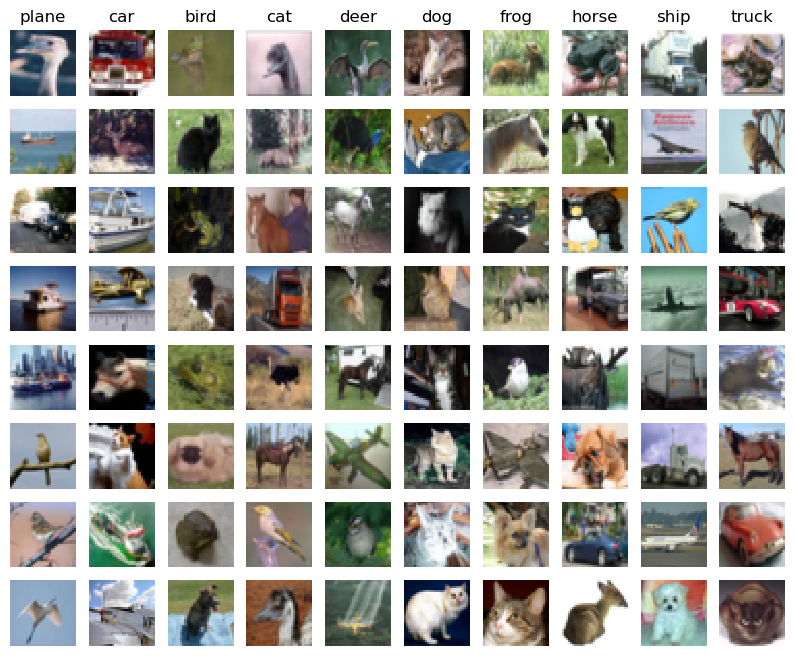

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Objects misclassified as planes all seem to have a long horizontal span, which makes sense given that HOG features capture the texture information.

Pictures misclassified as ship have a large blue area in the background, which makes sense given that color histograms capture color information.

$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 215)
(49000, 214)


Training exp0: lr = 3.295131561164248e-05, reg = 0.26381416207145597


100%|██████████| 24500/24500 [05:44<00:00, 71.12it/s]


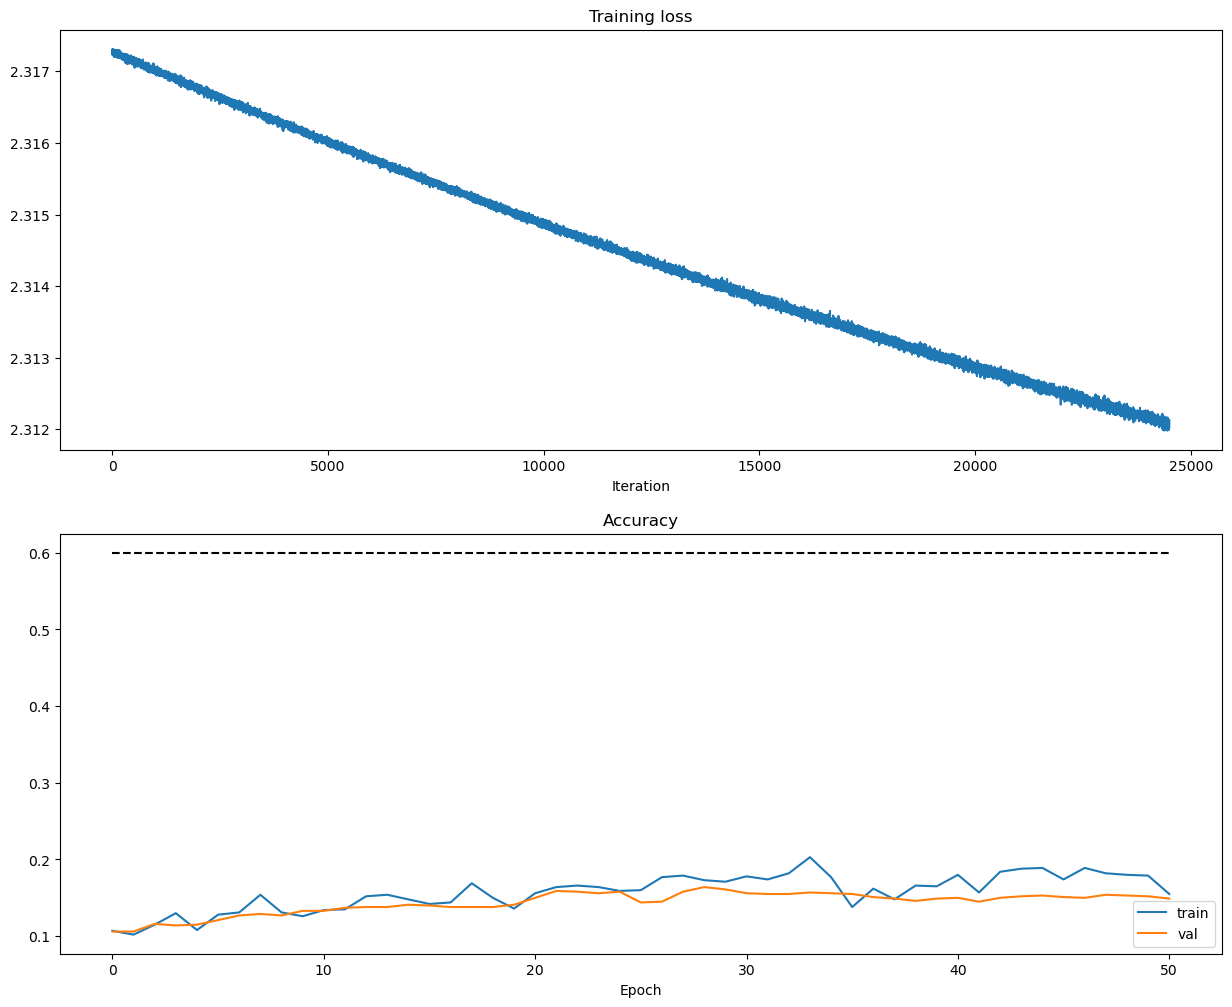

Training exp1: lr = 8.326547888804047e-05, reg = 0.27824555688542335


100%|██████████| 24500/24500 [05:43<00:00, 71.29it/s]


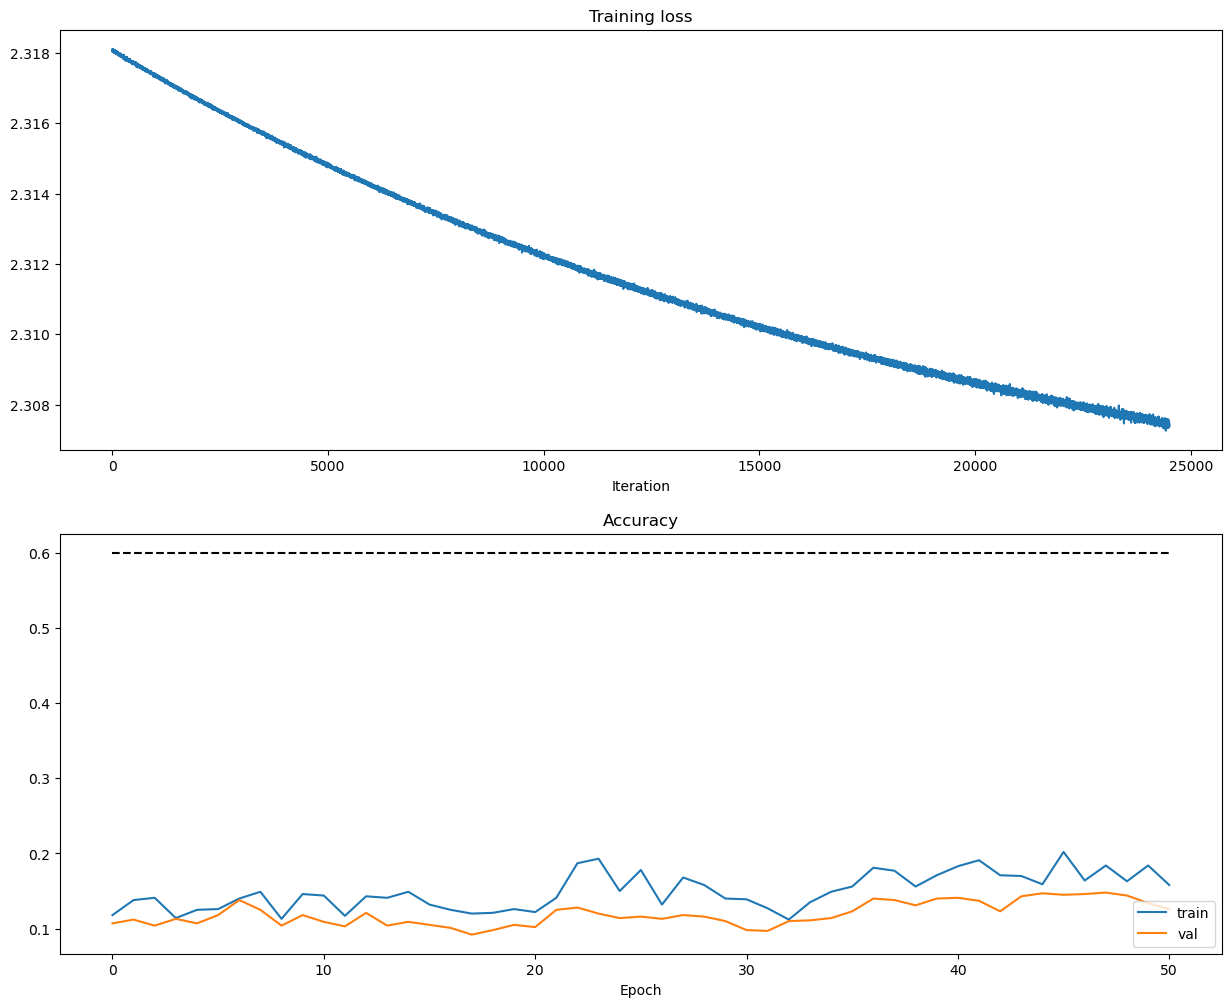

Training exp2: lr = 8.148493220232706e-06, reg = 29.80320346599041


100%|██████████| 24500/24500 [05:40<00:00, 72.04it/s]


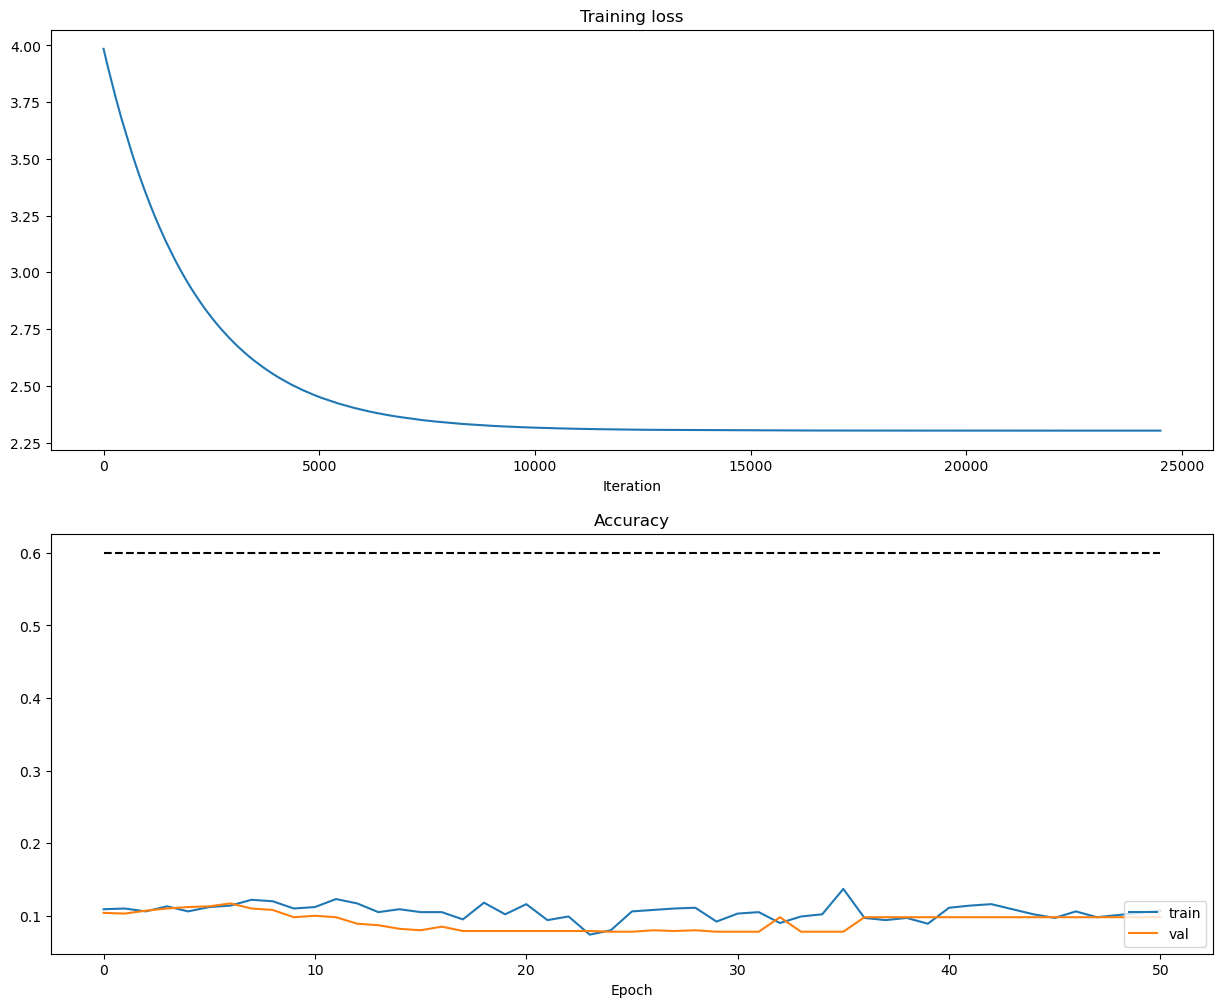

Training exp3: lr = 1.745148726536128e-06, reg = 0.011297933103598322


100%|██████████| 24500/24500 [05:42<00:00, 71.64it/s]


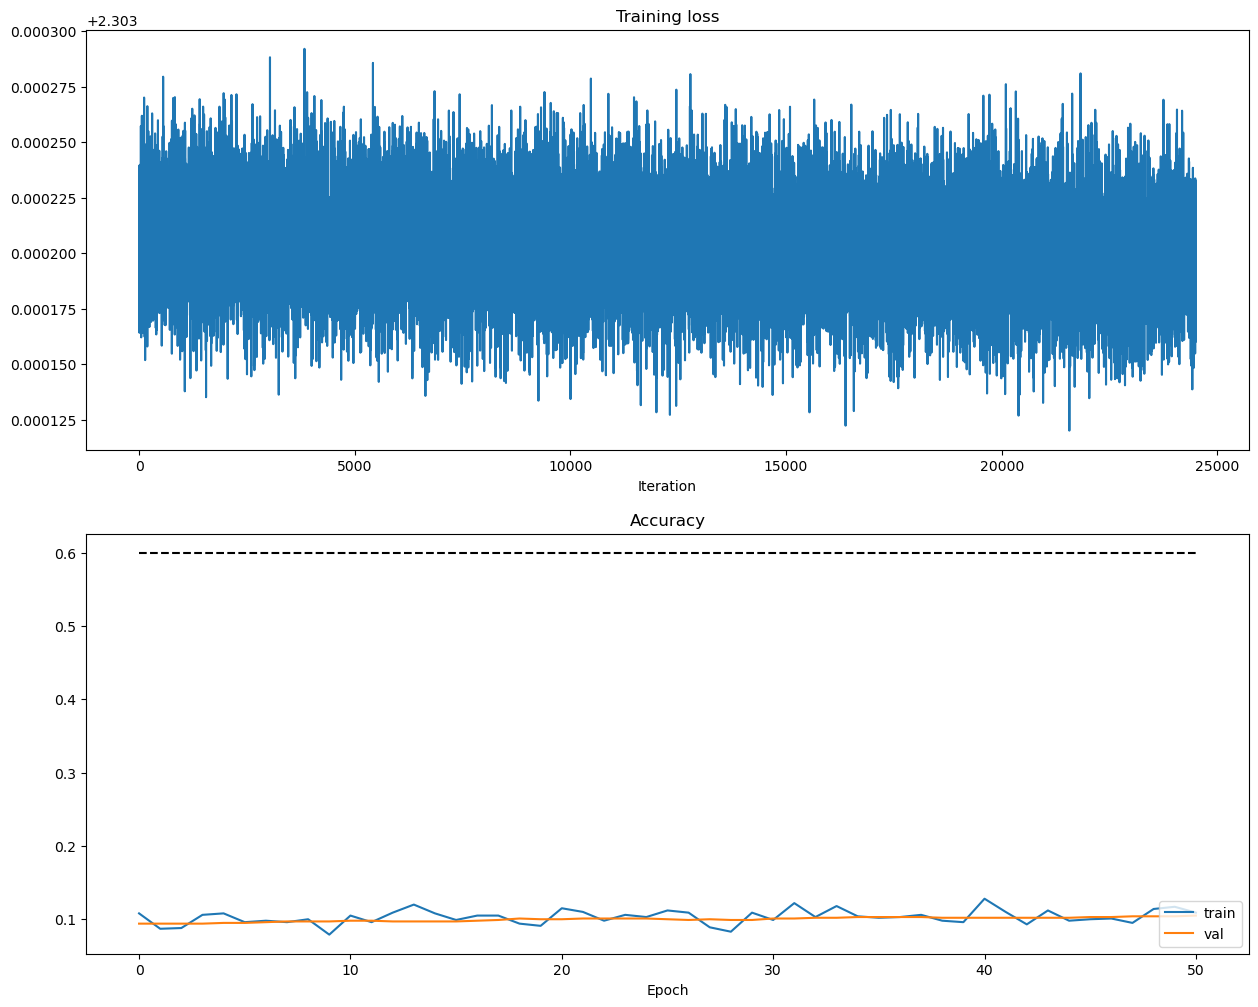

Training exp4: lr = 0.00034537719554336683, reg = 0.012568301884417746


100%|██████████| 24500/24500 [05:48<00:00, 70.23it/s]


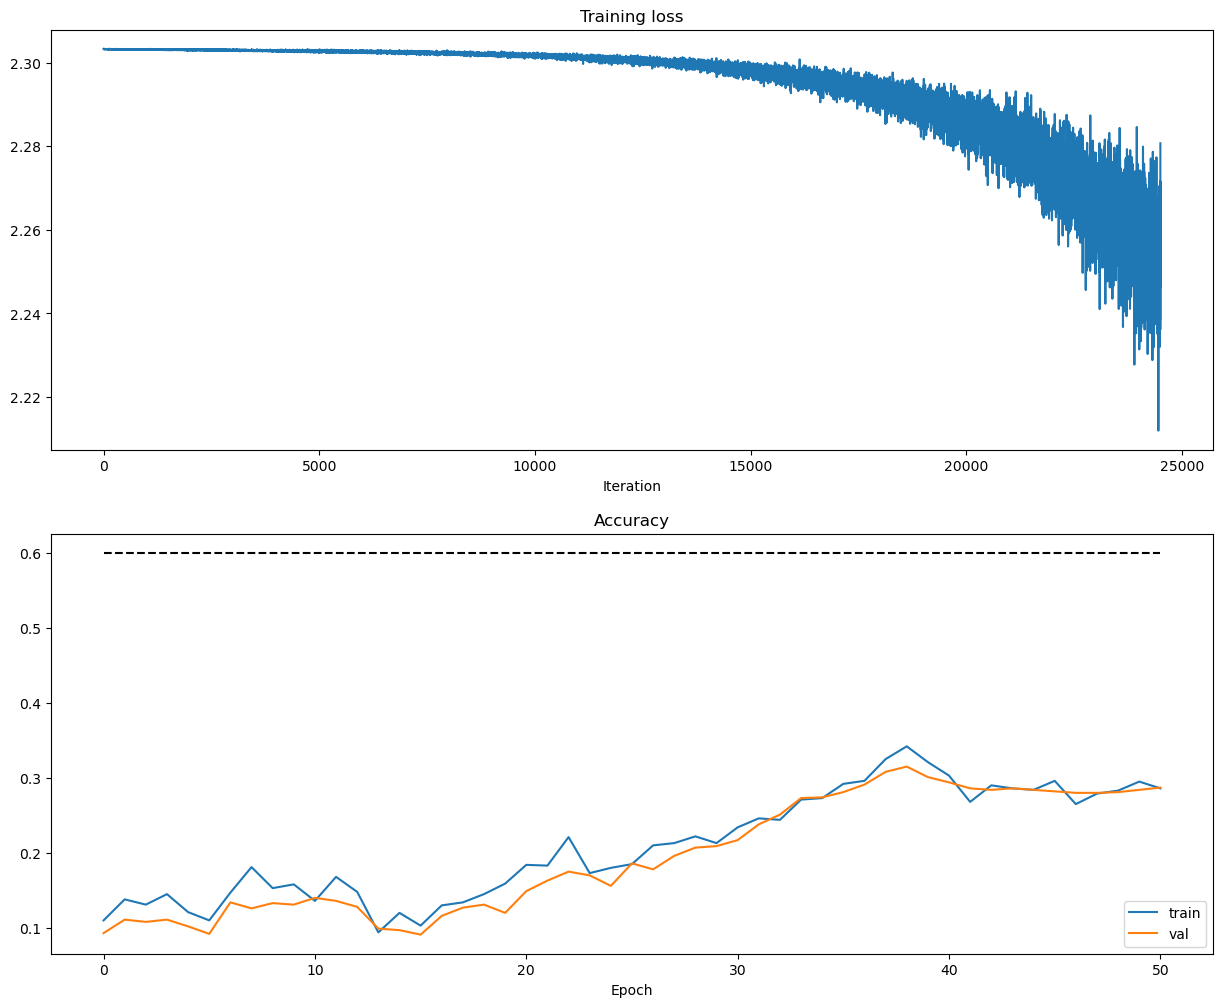

Training exp5: lr = 8.289864964011149e-05, reg = 70.18959744003092


100%|██████████| 24500/24500 [05:51<00:00, 69.63it/s]


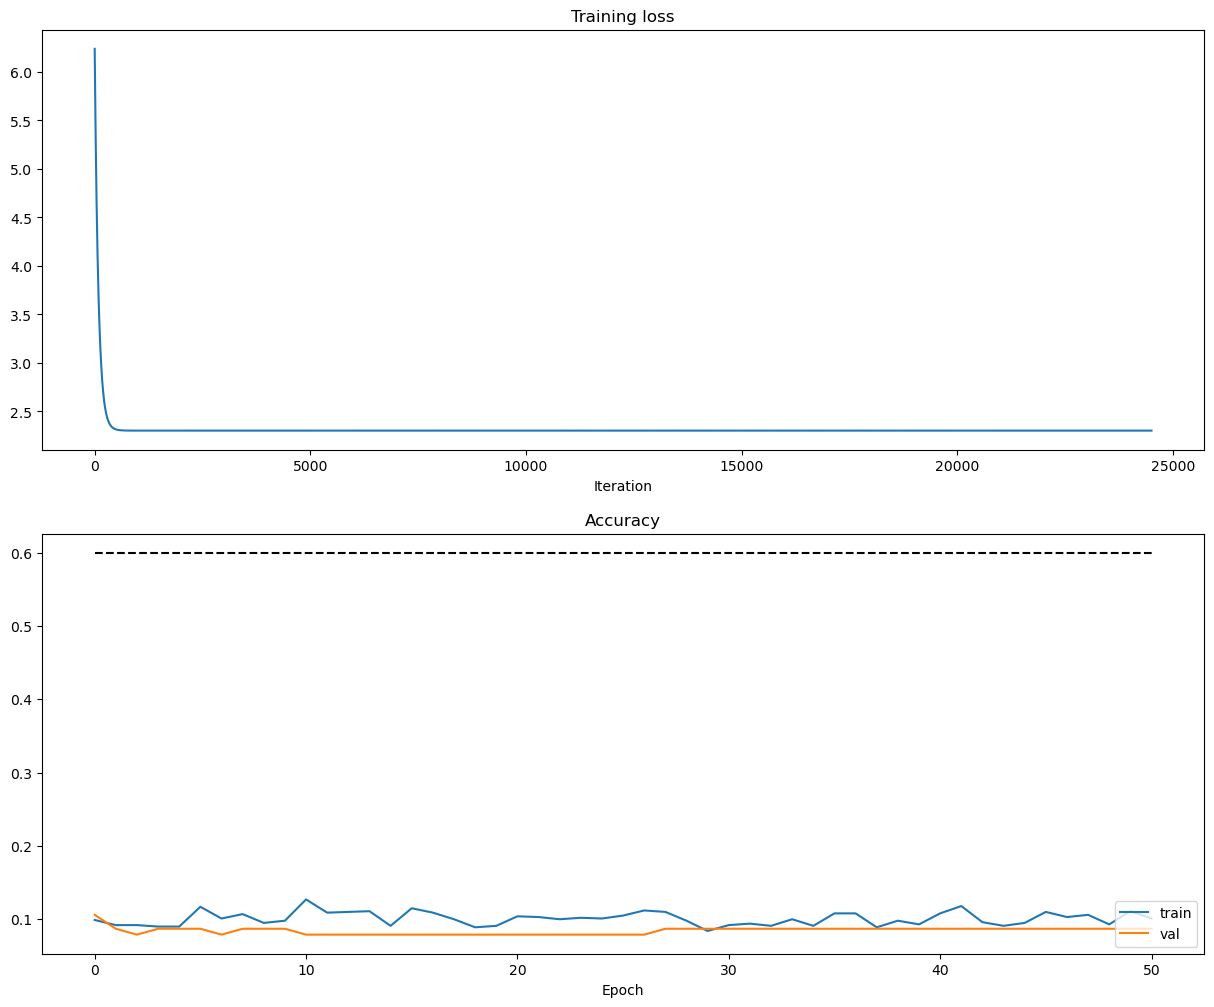

Training exp6: lr = 4.537191949795045e-05, reg = 0.3539532955964486


100%|██████████| 24500/24500 [05:51<00:00, 69.69it/s]


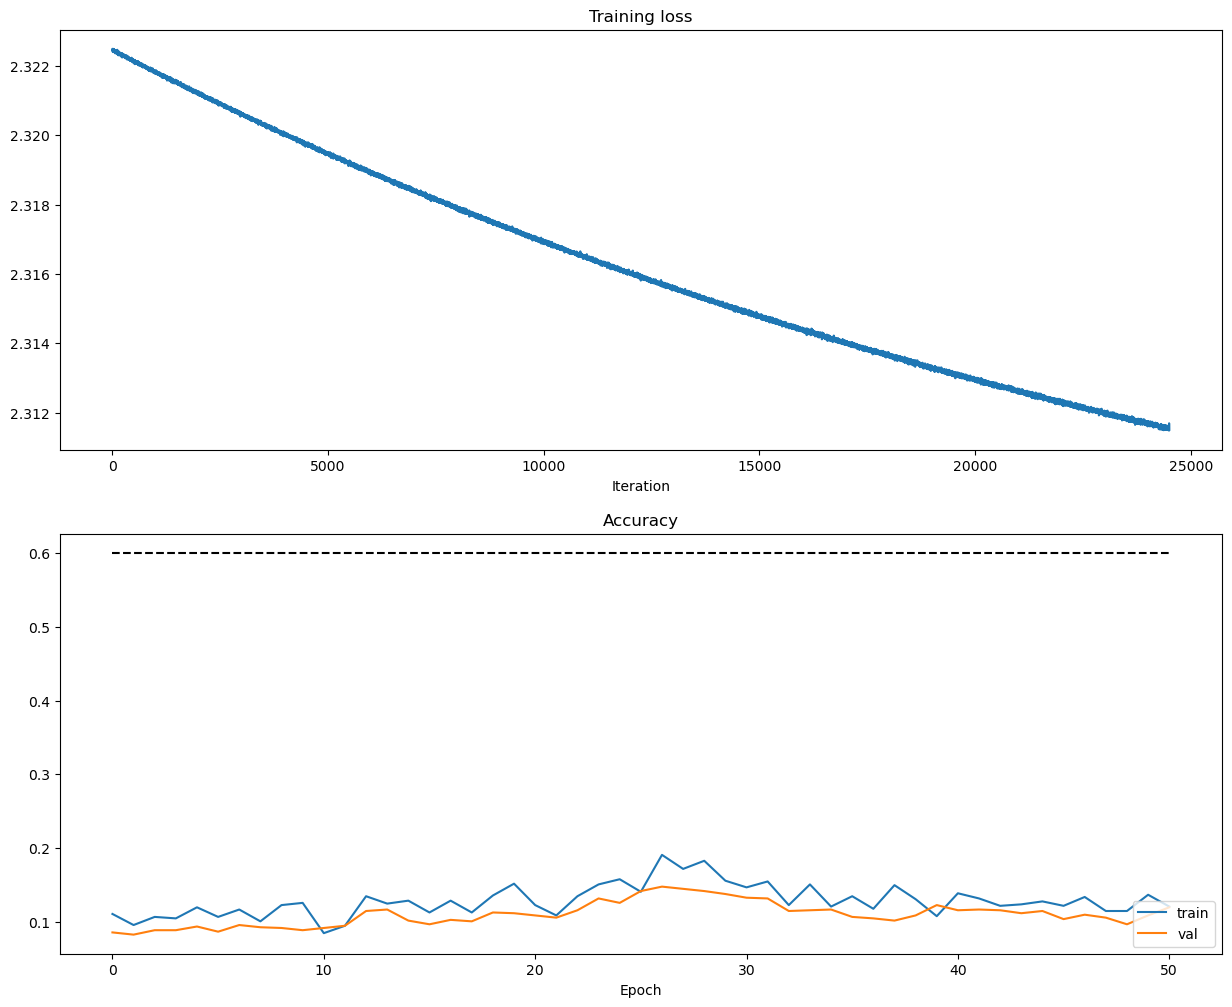

Training exp7: lr = 1.4310517328822242e-06, reg = 0.09374222031183847


100%|██████████| 24500/24500 [05:41<00:00, 71.72it/s]


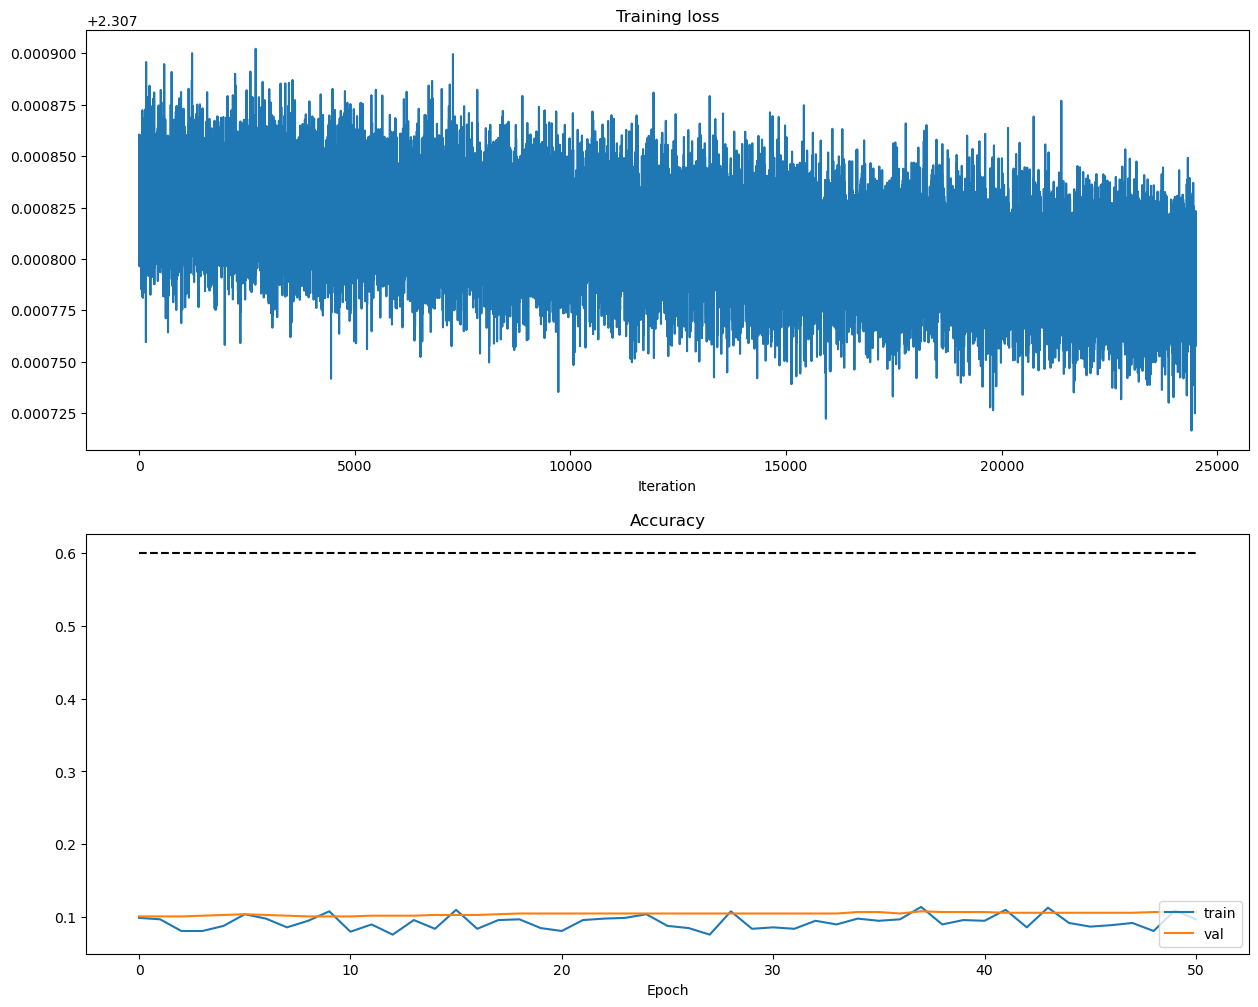

Training exp8: lr = 3.566836803612405e-05, reg = 20.794410325933743


100%|██████████| 24500/24500 [05:42<00:00, 71.59it/s]


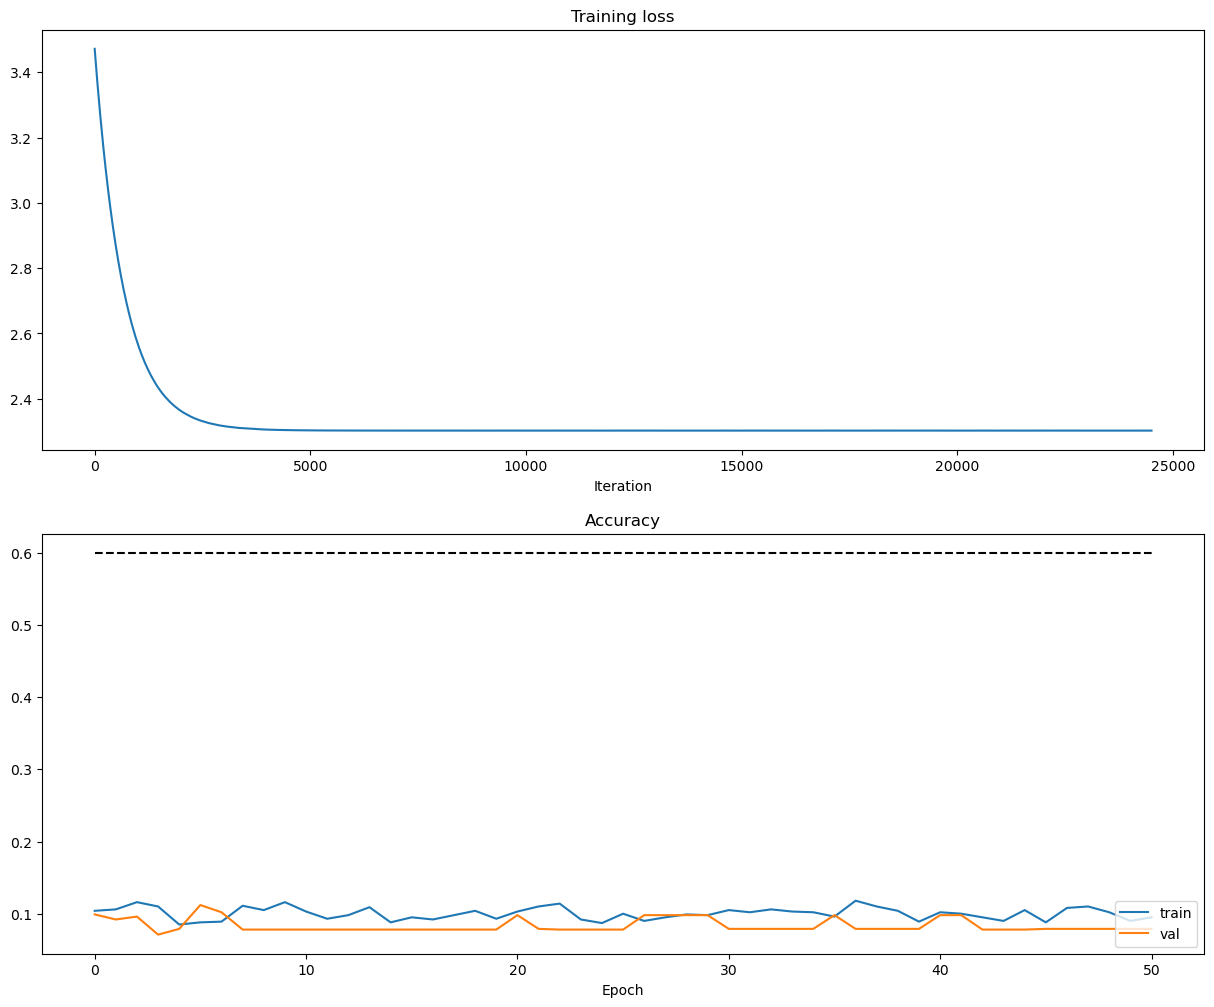

Training exp9: lr = 0.0005749901046750589, reg = 0.08949786434312924


100%|██████████| 24500/24500 [05:57<00:00, 68.44it/s]


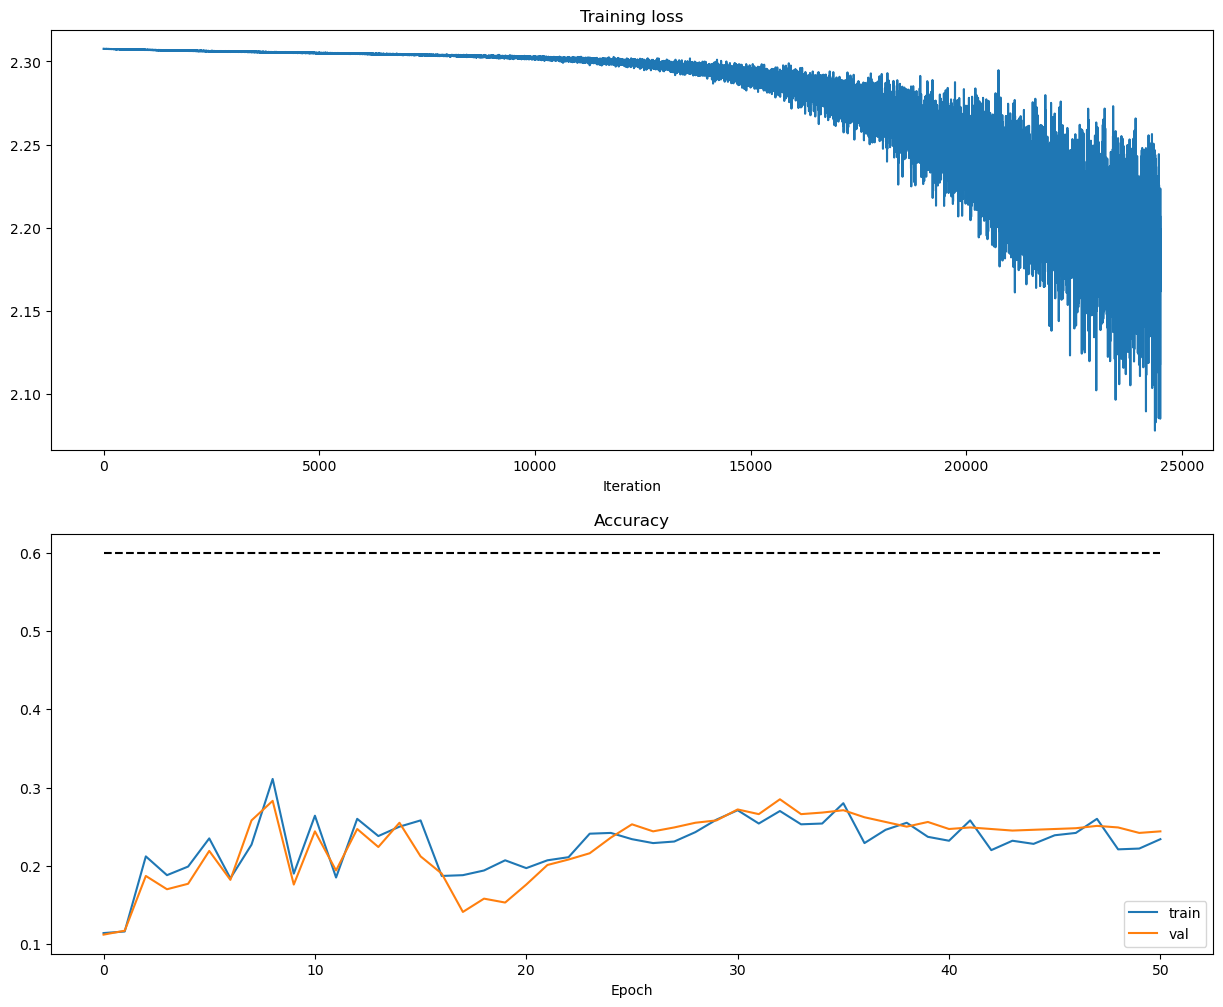

In [13]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val_acc = -1

for i in range(10):
    lr = 10 ** np.random.uniform(-6, -2)
    reg = 10 ** np.random.uniform(-2, 2)

    print(f'Training exp{i}: lr = {lr}, reg = {reg}')
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg)
    solver = Solver(net, data, optim_config={'learning_rate': lr}, num_epochs=50, verbose=False)
    solver.train()

    plt.subplot(2, 1, 1)
    plt.title('Training loss')
    plt.plot(solver.loss_history)
    plt.xlabel('Iteration')
    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(solver.train_acc_history, label='train')
    plt.plot(solver.val_acc_history, label='val')
    plt.plot([0.6] * len(solver.val_acc_history), 'k--')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()

    if solver.best_val_acc > best_val_acc:
        best_val_acc = solver.best_val_acc
        best_net = solver.model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Training exp0: lr = 0.0005735027960447974, reg = 0.029733239122371333


100%|██████████| 24500/24500 [05:50<00:00, 69.91it/s]


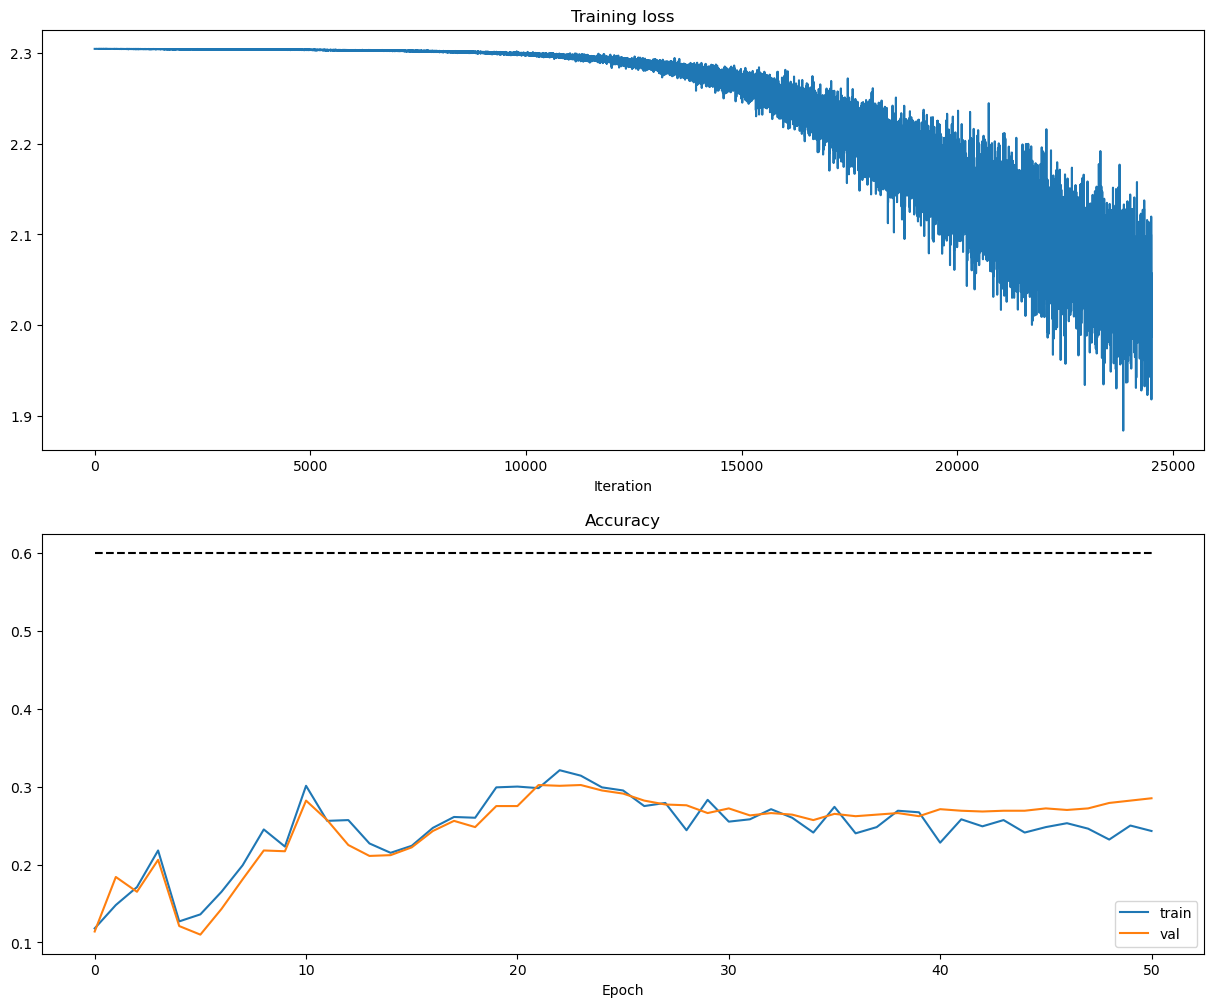

Training exp1: lr = 0.0014277809470457292, reg = 0.0022151675062609664


100%|██████████| 24500/24500 [05:49<00:00, 70.10it/s]


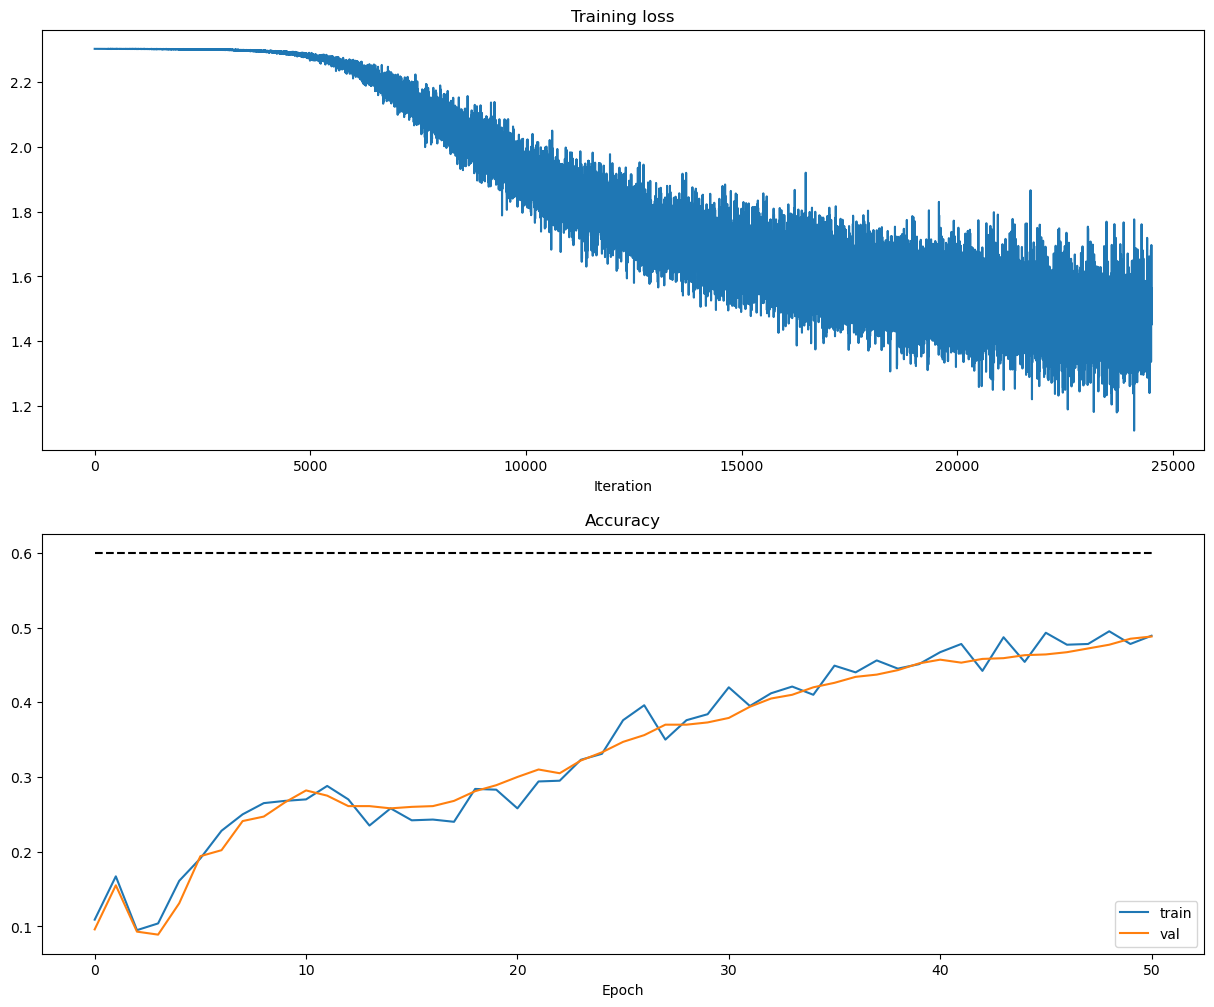

Training exp2: lr = 0.0003884451230953592, reg = 0.025678438974267893


100%|██████████| 24500/24500 [05:50<00:00, 69.98it/s]


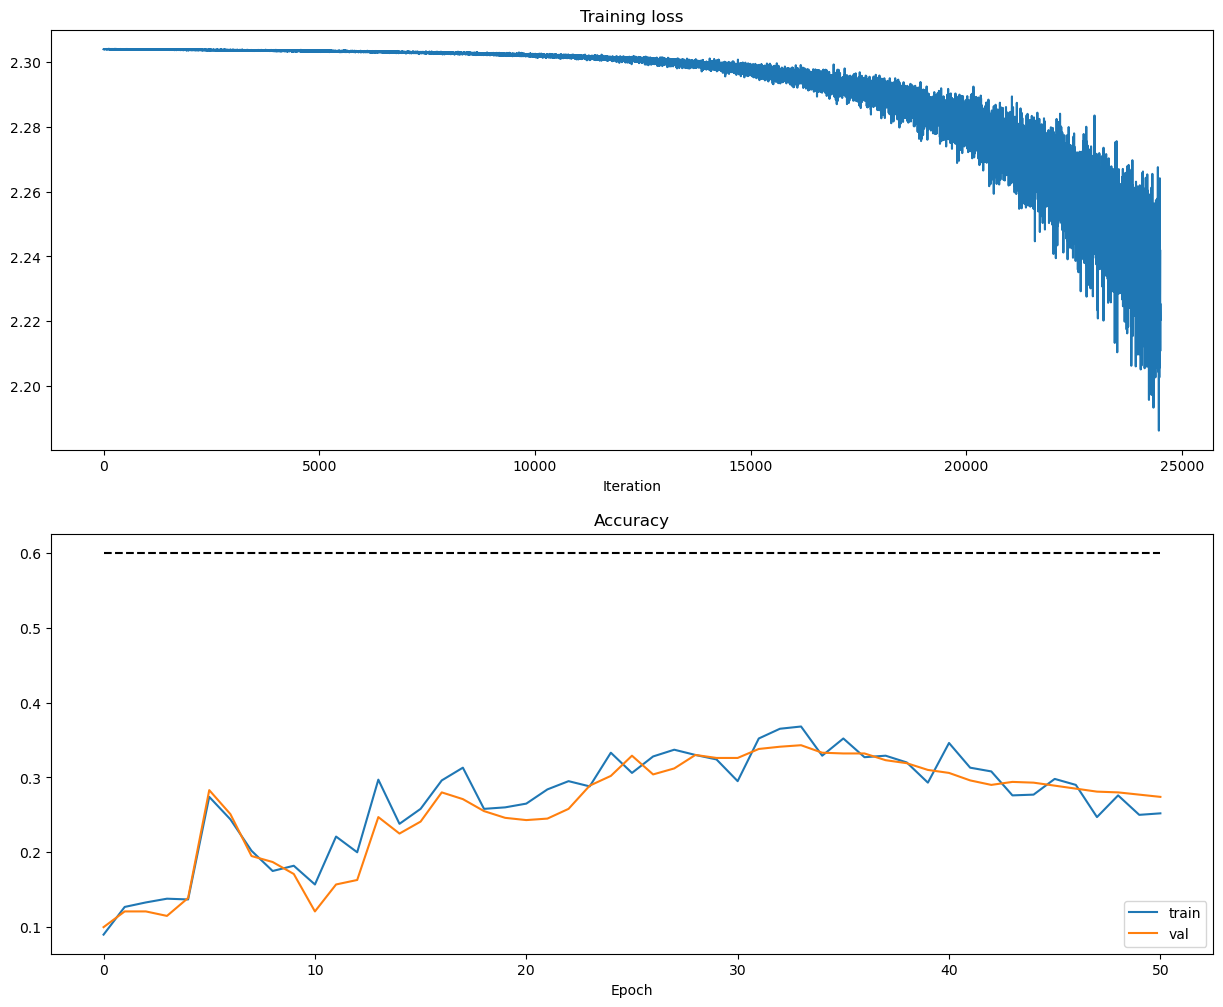

Training exp3: lr = 0.008314986684504125, reg = 0.001972865409017013


100%|██████████| 24500/24500 [05:46<00:00, 70.77it/s]


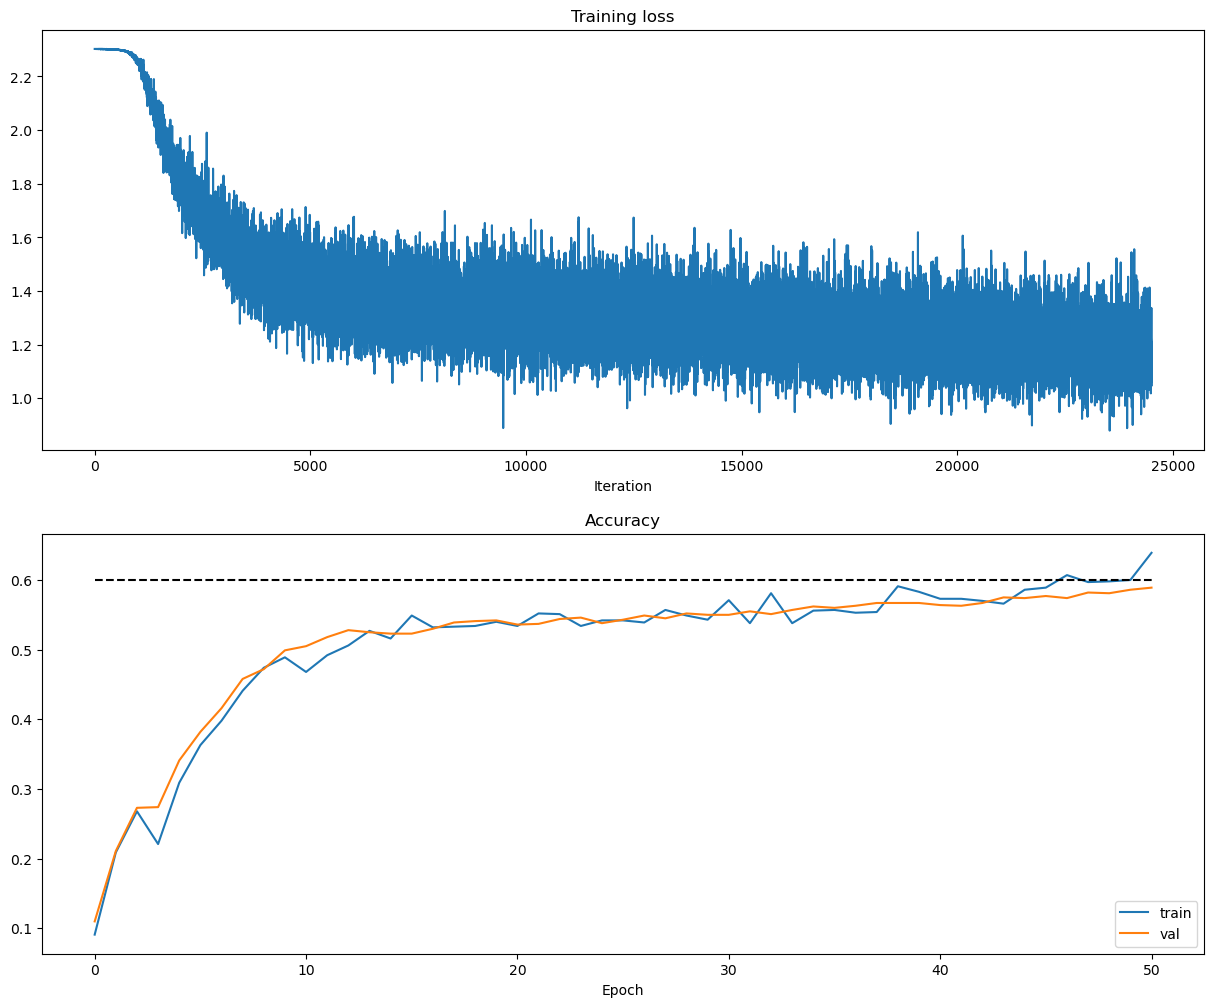

Training exp4: lr = 0.005467953974172242, reg = 0.03292310037578652


100%|██████████| 24500/24500 [05:50<00:00, 69.83it/s]


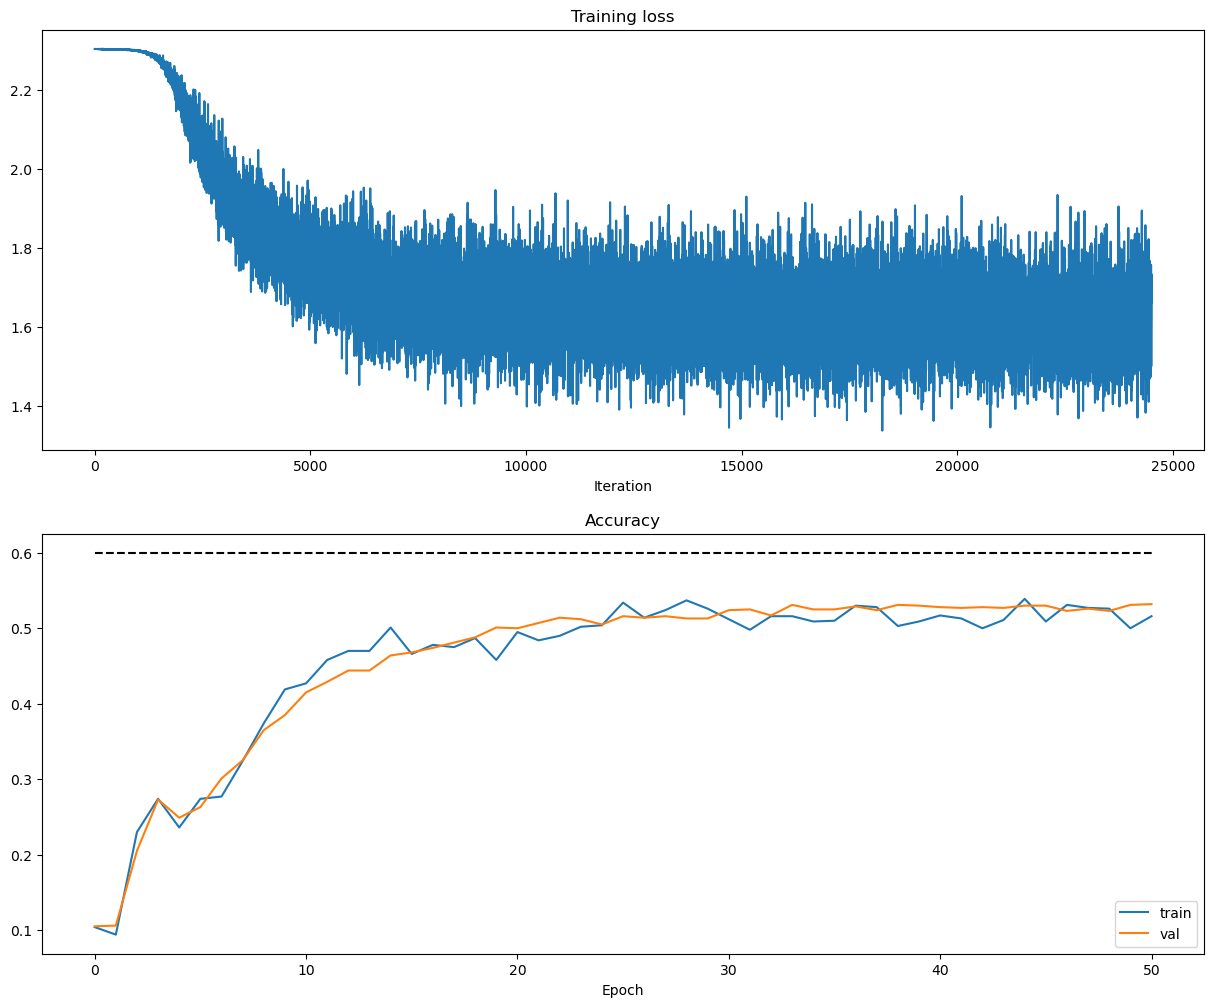

Training exp5: lr = 0.00167711795804171, reg = 0.0035140804736876275


100%|██████████| 24500/24500 [05:47<00:00, 70.55it/s]


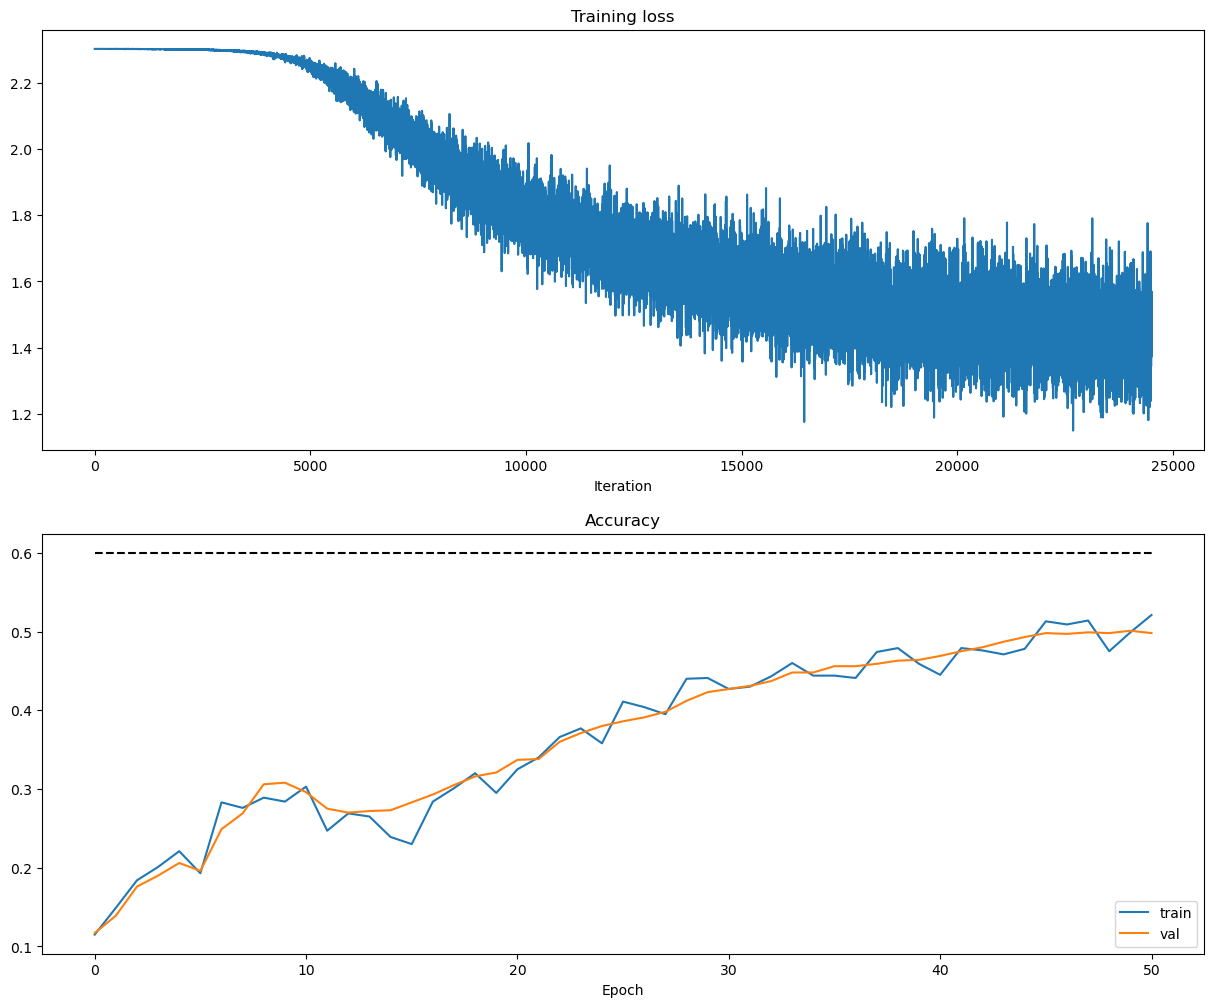

Training exp6: lr = 0.001679954105618665, reg = 0.00021109738213171618


100%|██████████| 24500/24500 [05:48<00:00, 70.21it/s]


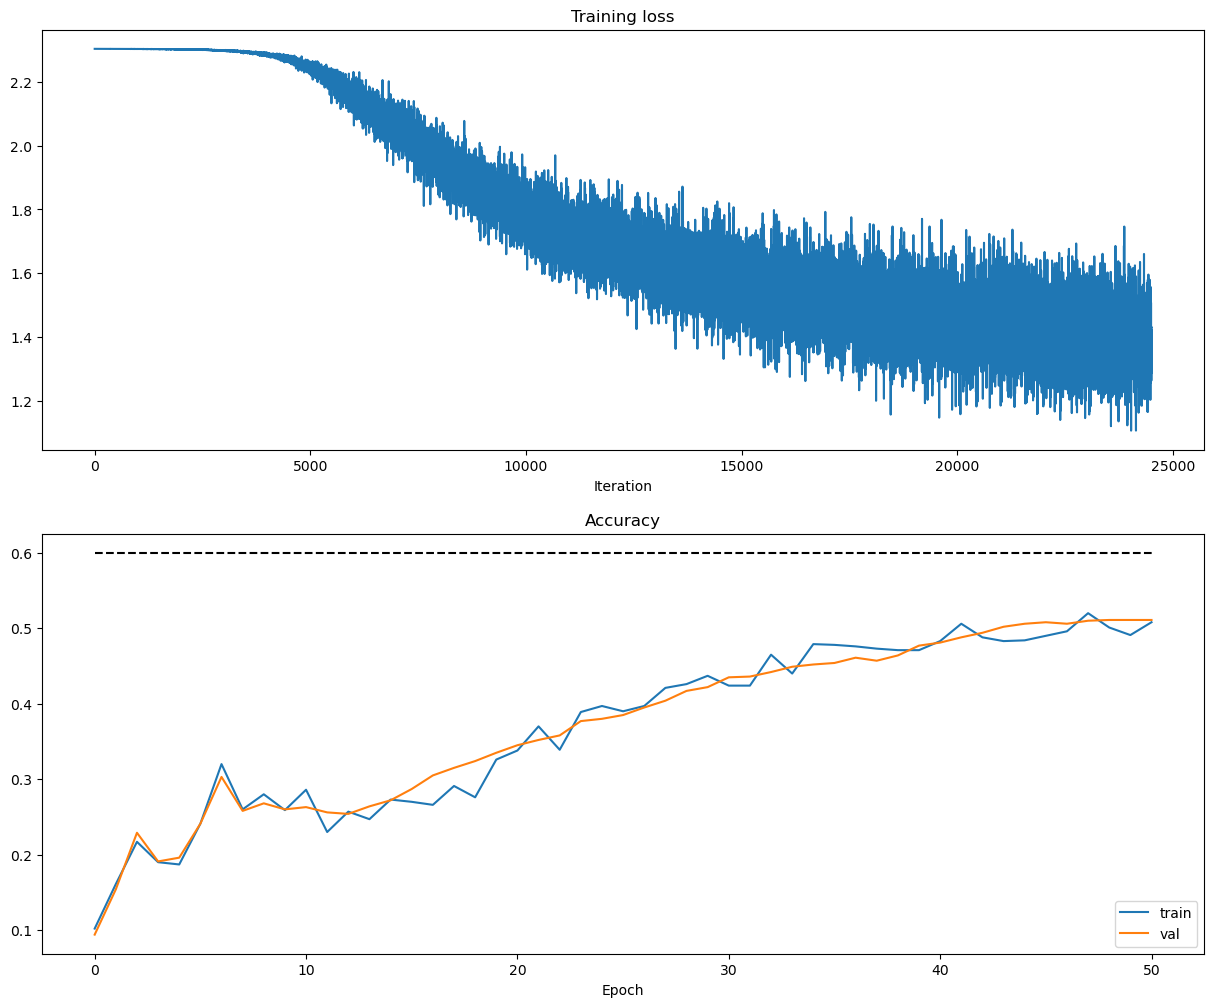

Training exp7: lr = 0.0063682555893695945, reg = 0.00684696816370977


100%|██████████| 24500/24500 [05:46<00:00, 70.67it/s]


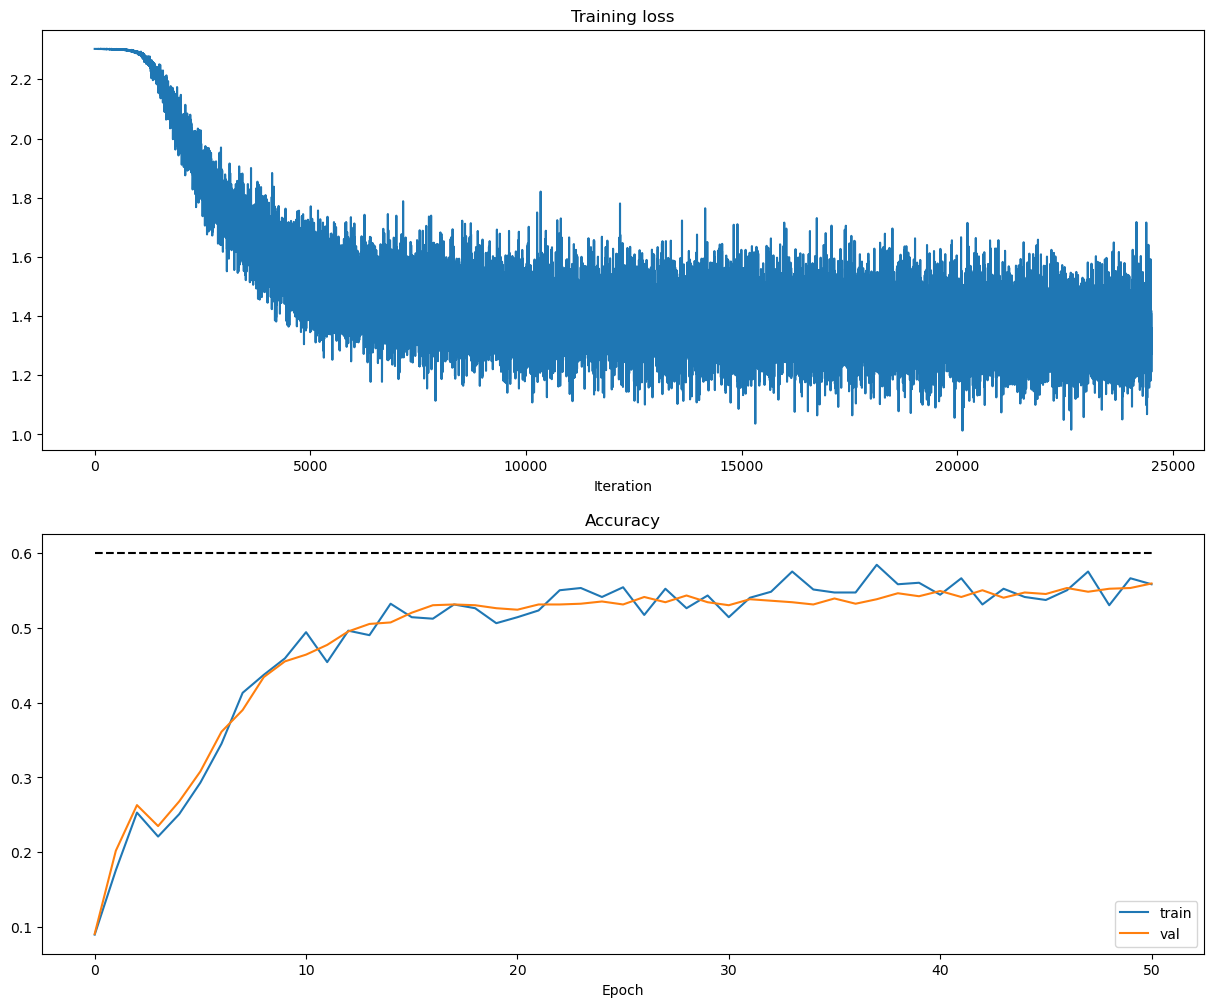

Training exp8: lr = 0.002856707466400687, reg = 0.02029877750041851


100%|██████████| 24500/24500 [05:47<00:00, 70.52it/s]


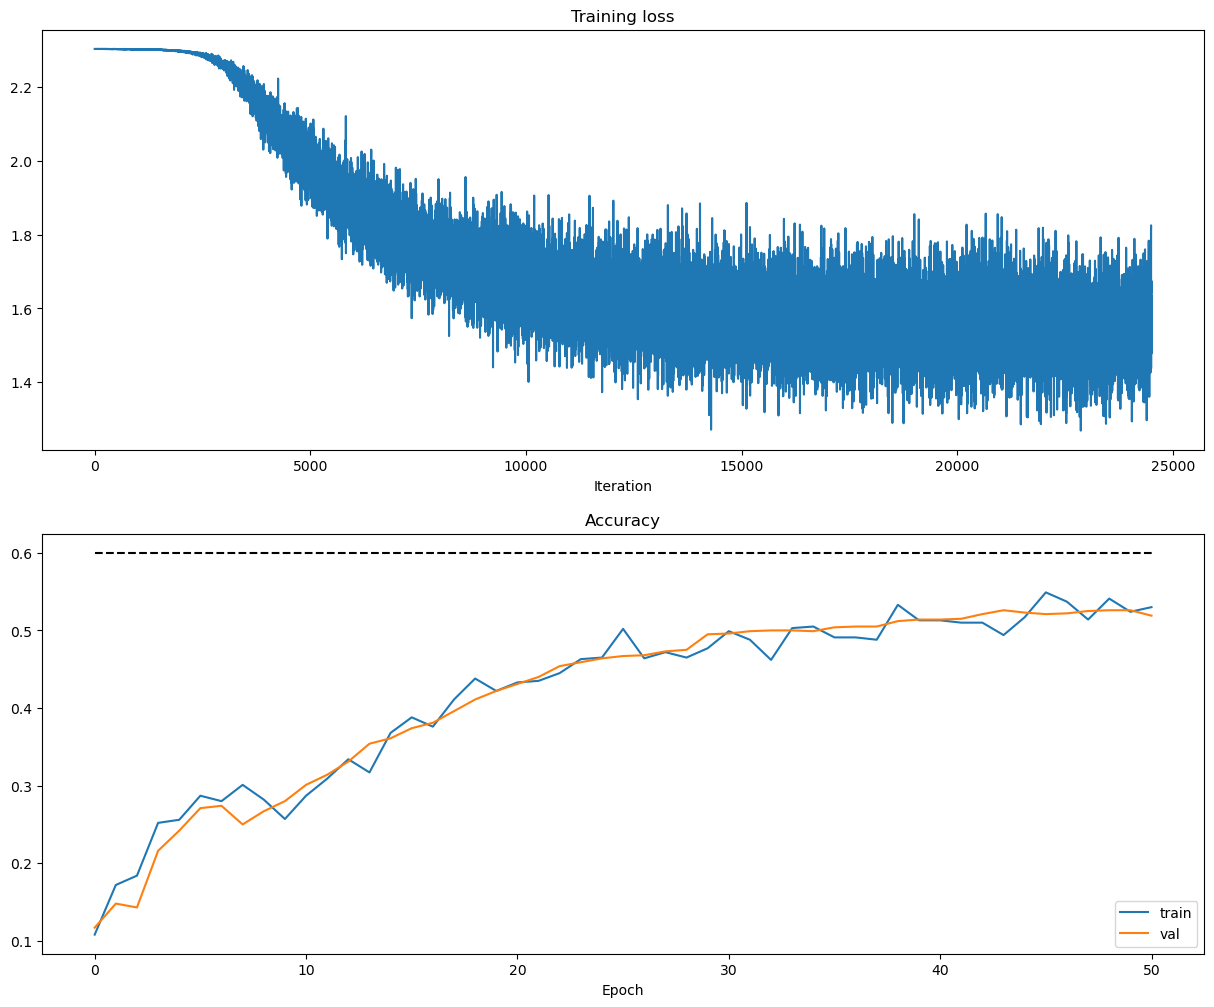

Training exp9: lr = 0.008933541893010054, reg = 0.00019200003619610458


100%|██████████| 24500/24500 [05:46<00:00, 70.72it/s]


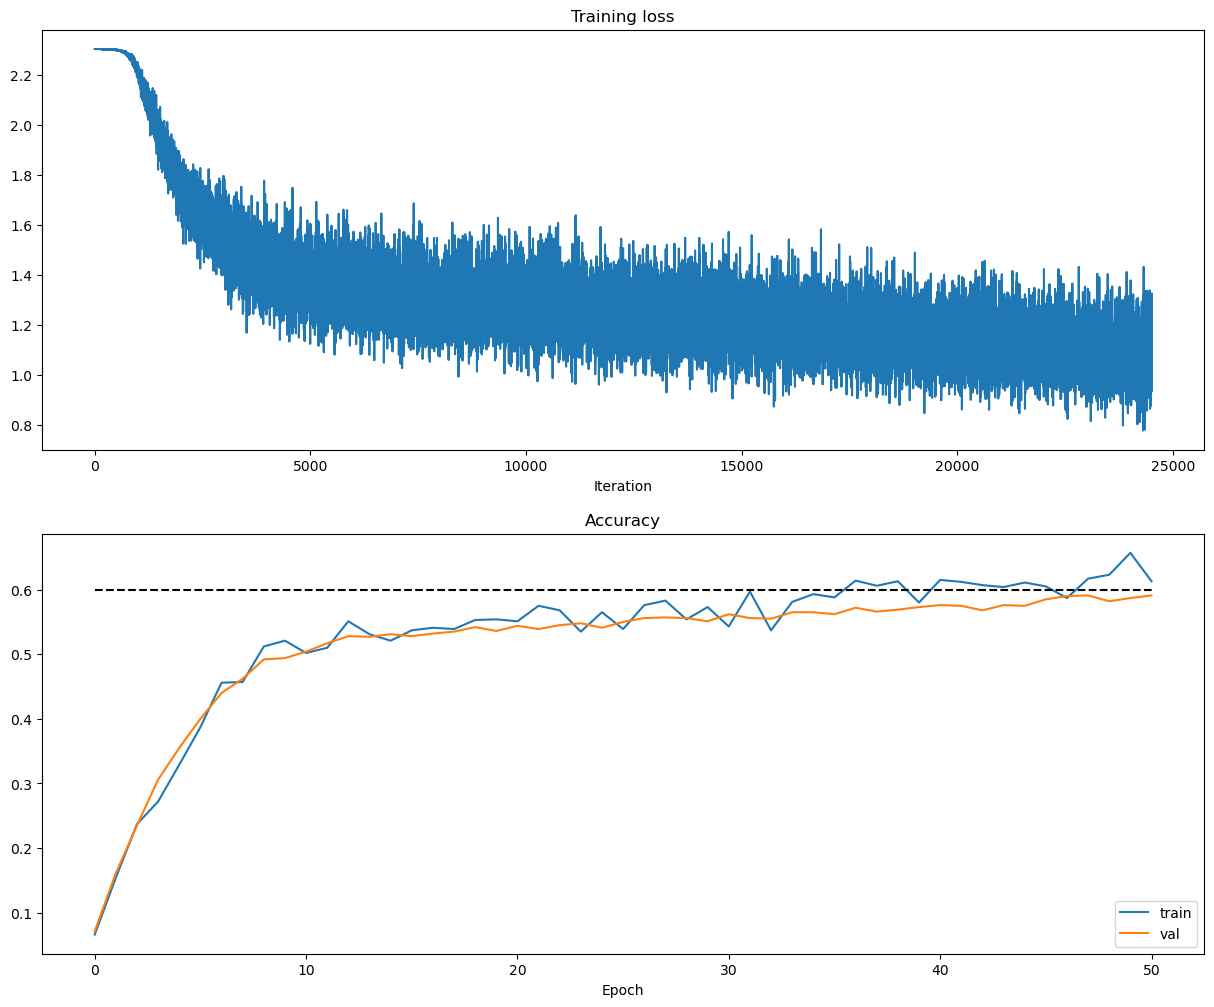

In [14]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val_acc = -1

for i in range(10):
    lr = 10 ** np.random.uniform(-4, -2)
    reg = 10 ** np.random.uniform(-5, 0)

    print(f'Training exp{i}: lr = {lr}, reg = {reg}')
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg)
    solver = Solver(net, data, optim_config={'learning_rate': lr}, num_epochs=50, verbose=False)
    solver.train()

    plt.subplot(2, 1, 1)
    plt.title('Training loss')
    plt.plot(solver.loss_history)
    plt.xlabel('Iteration')
    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(solver.train_acc_history, label='train')
    plt.plot(solver.val_acc_history, label='val')
    plt.plot([0.6] * len(solver.val_acc_history), 'k--')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()

    if solver.best_val_acc > best_val_acc:
        best_val_acc = solver.best_val_acc
        best_net = solver.model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Training exp 0: lr = 0.00738898625118247, hidden_dim = 1156, reg = 0.04163433789339676


  0%|          | 0/24500 [00:00<?, ?it/s]

100%|██████████| 24500/24500 [13:55<00:00, 29.33it/s]


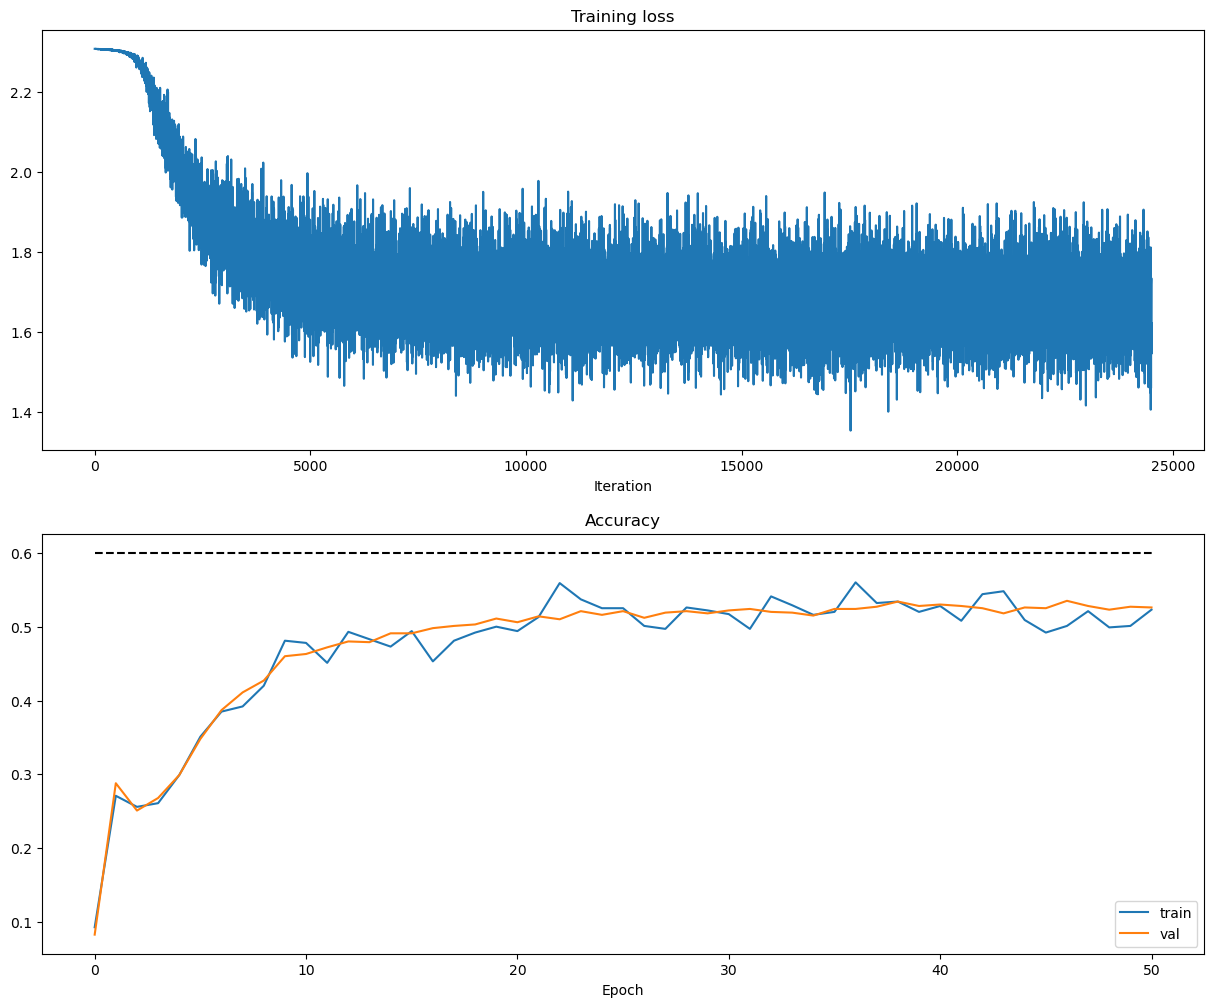

best_val_acc: 0.535
Training exp 1: lr = 0.002747529585661208, hidden_dim = 3803, reg = 0.00579539822013253


100%|██████████| 24500/24500 [49:18<00:00,  8.28it/s] 


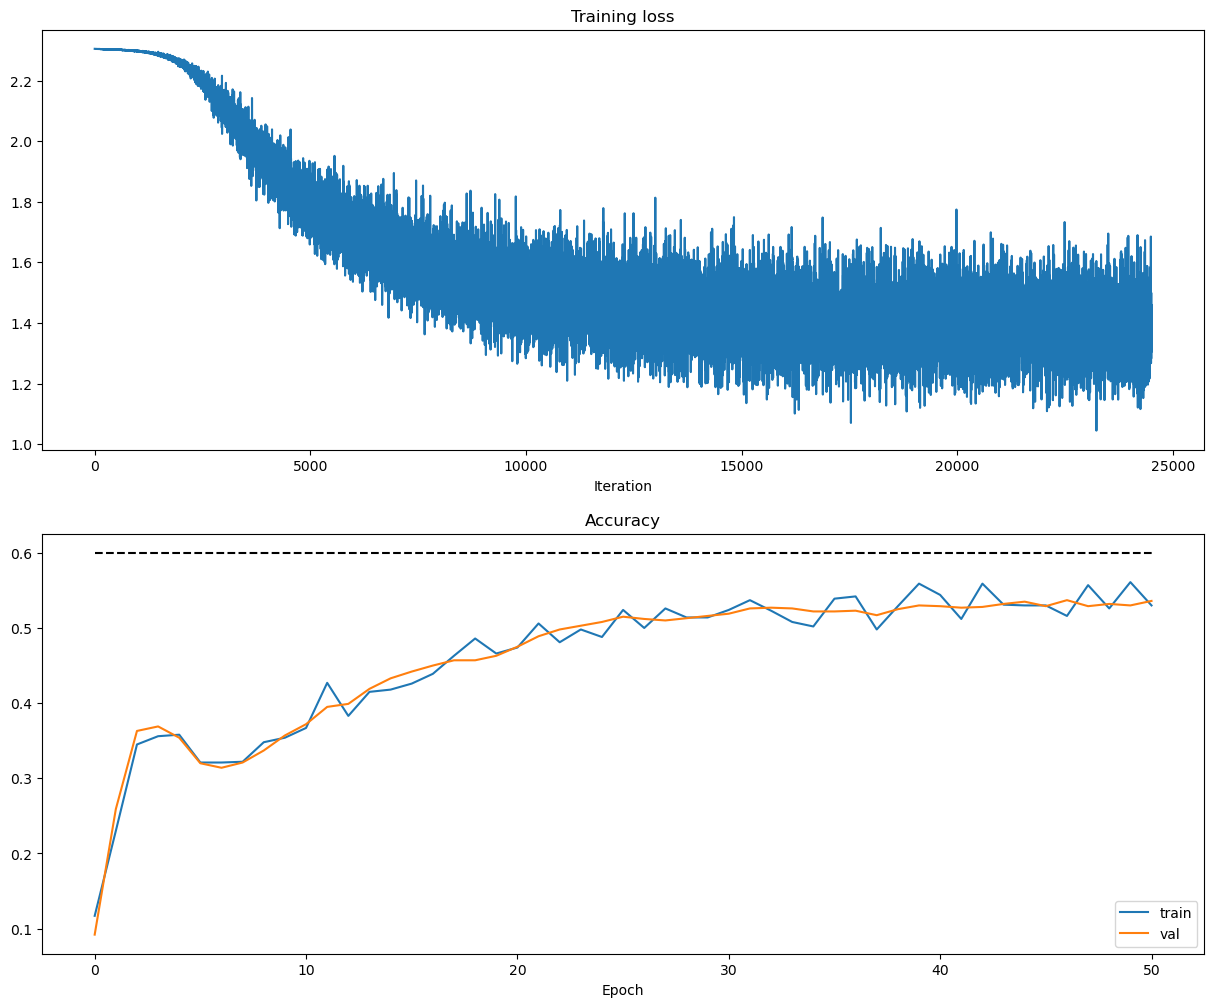

best_val_acc: 0.537
Training exp 2: lr = 0.013335618311604536, hidden_dim = 897, reg = 0.0010940877972440543


100%|██████████| 24500/24500 [10:55<00:00, 37.35it/s]


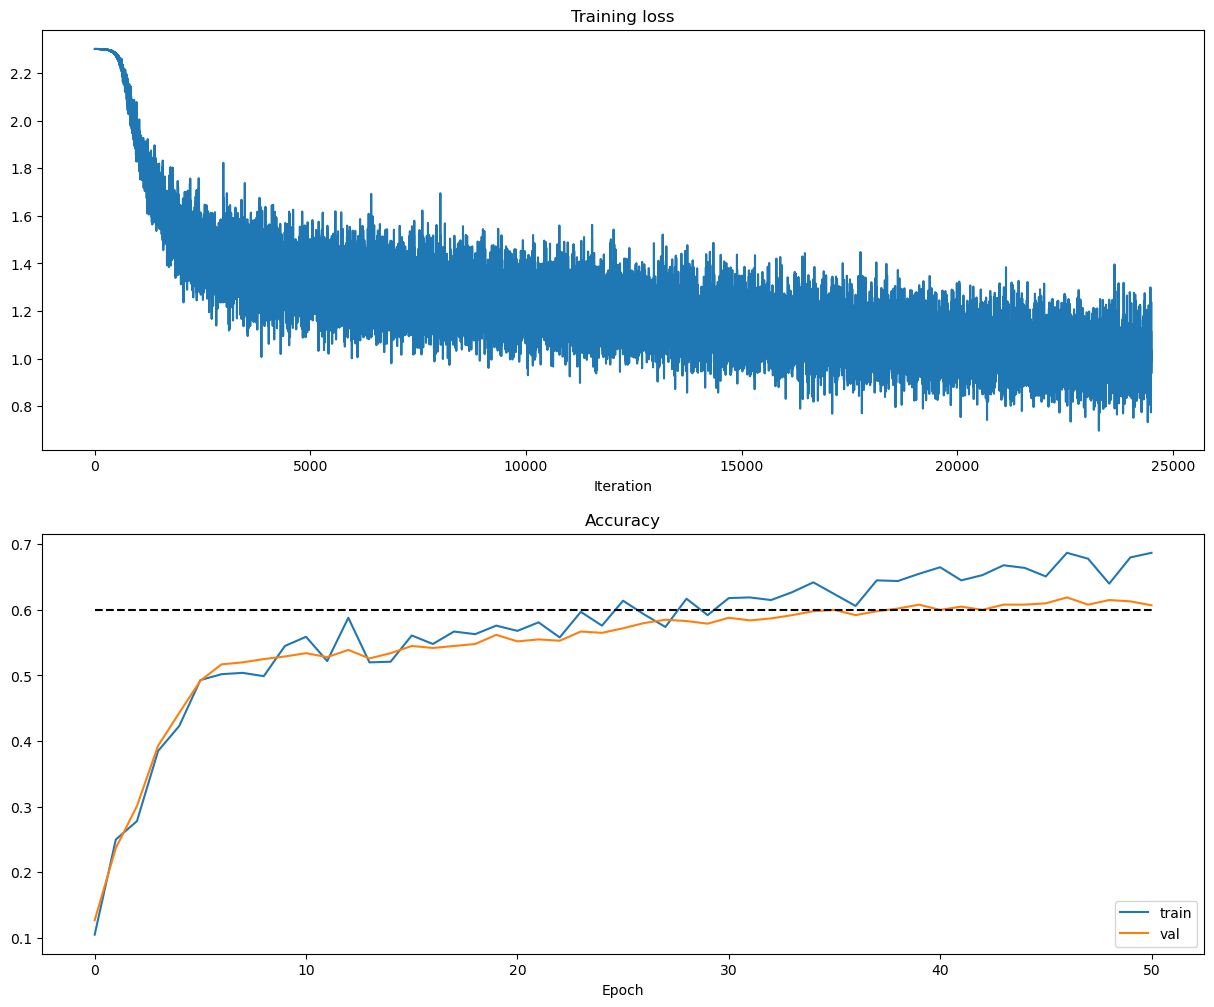

best_val_acc: 0.619
Training exp 3: lr = 0.017355444187486958, hidden_dim = 3032, reg = 0.43941033678031743


100%|██████████| 24500/24500 [37:12<00:00, 10.98it/s]


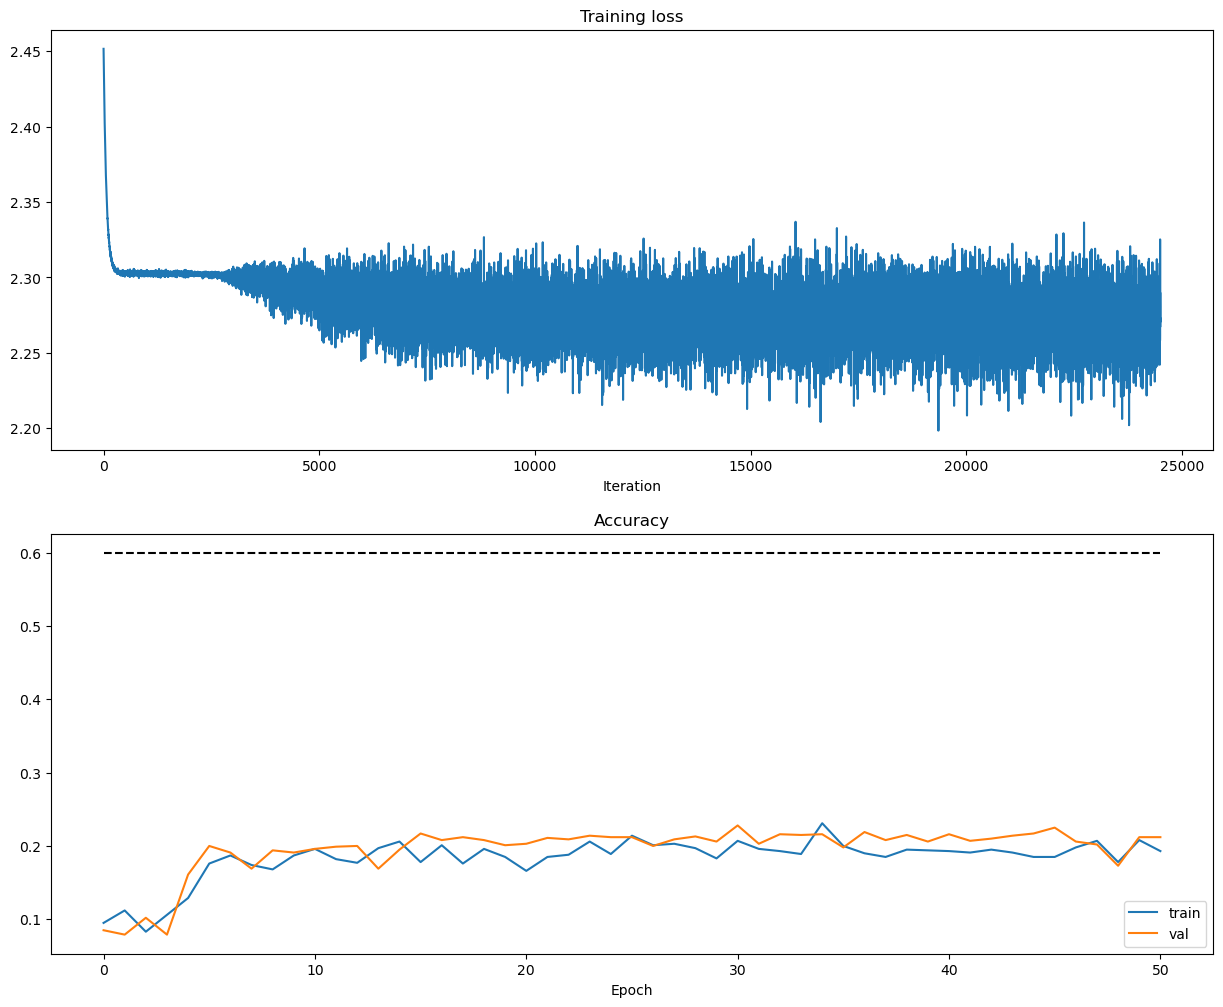

best_val_acc: 0.228
Training exp 4: lr = 0.0018892255353790246, hidden_dim = 665, reg = 7.876666867231213e-05


100%|██████████| 24500/24500 [07:55<00:00, 51.55it/s]


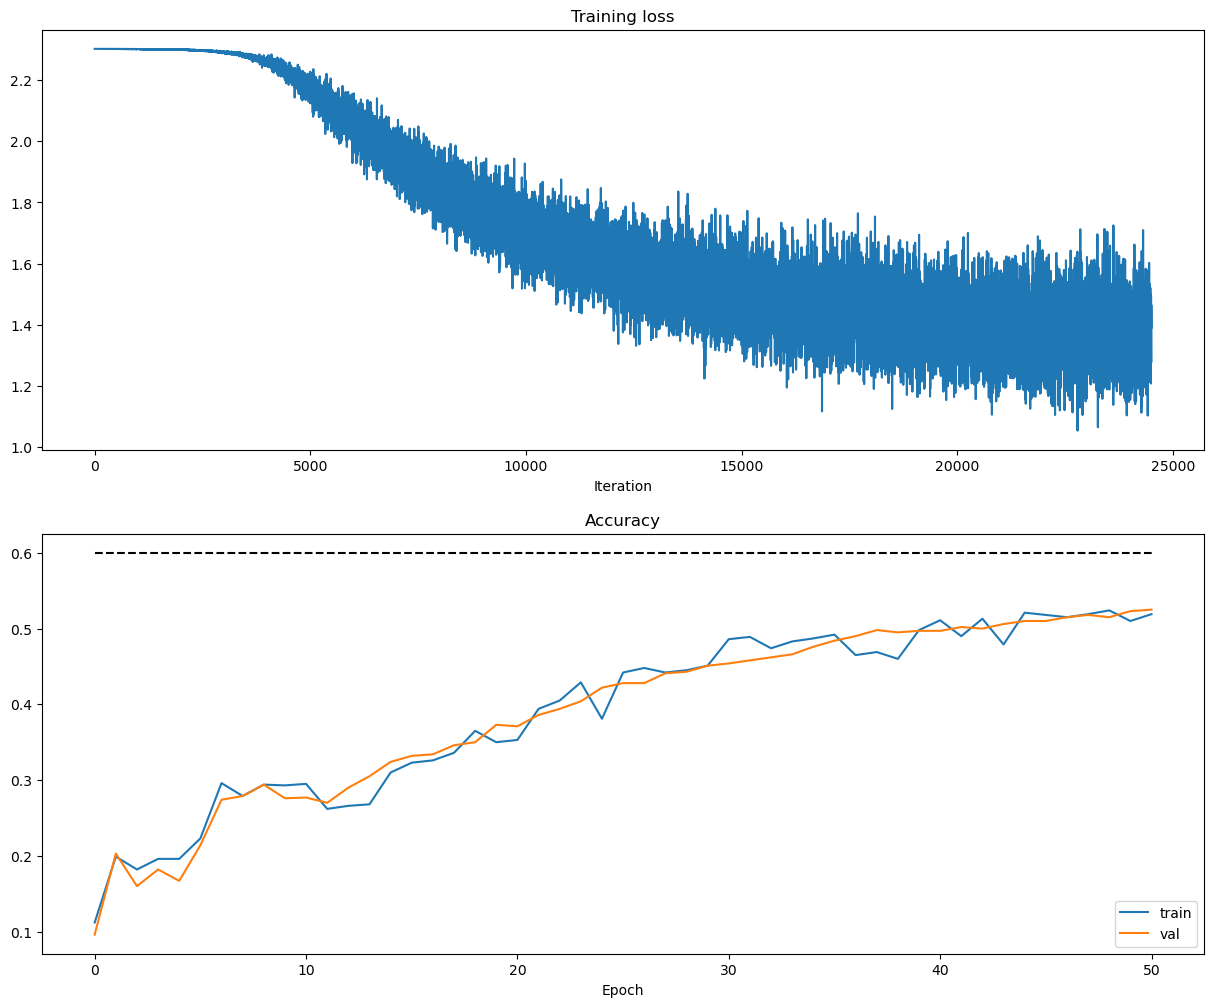

best_val_acc: 0.525
Training exp 5: lr = 0.021745787569972655, hidden_dim = 4307, reg = 0.012208176439854147


100%|██████████| 24500/24500 [55:22<00:00,  7.37it/s] 


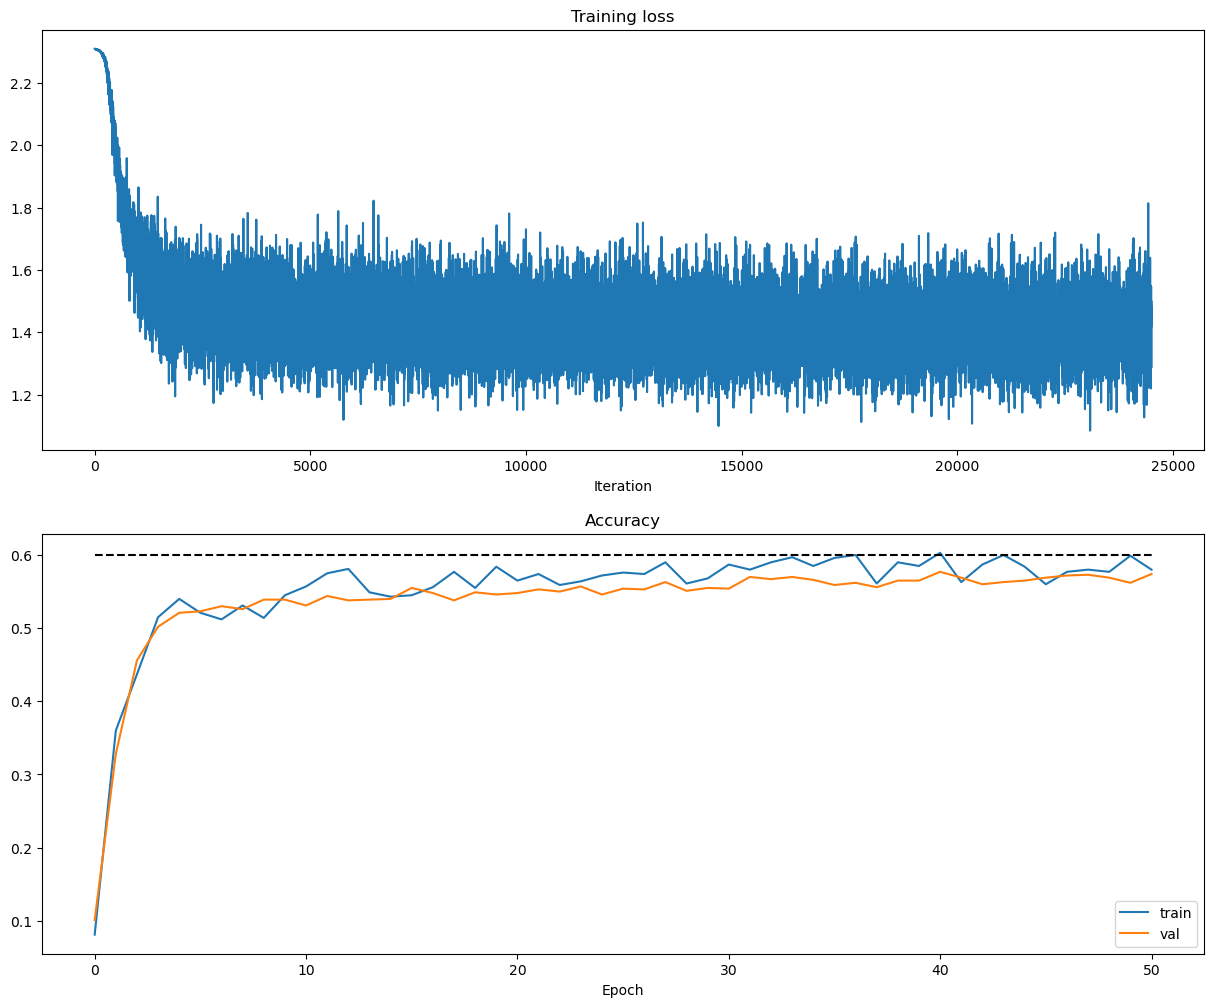

best_val_acc: 0.577
Training exp 6: lr = 0.027723388166238344, hidden_dim = 3274, reg = 0.008918888997063572


100%|██████████| 24500/24500 [40:07<00:00, 10.18it/s]


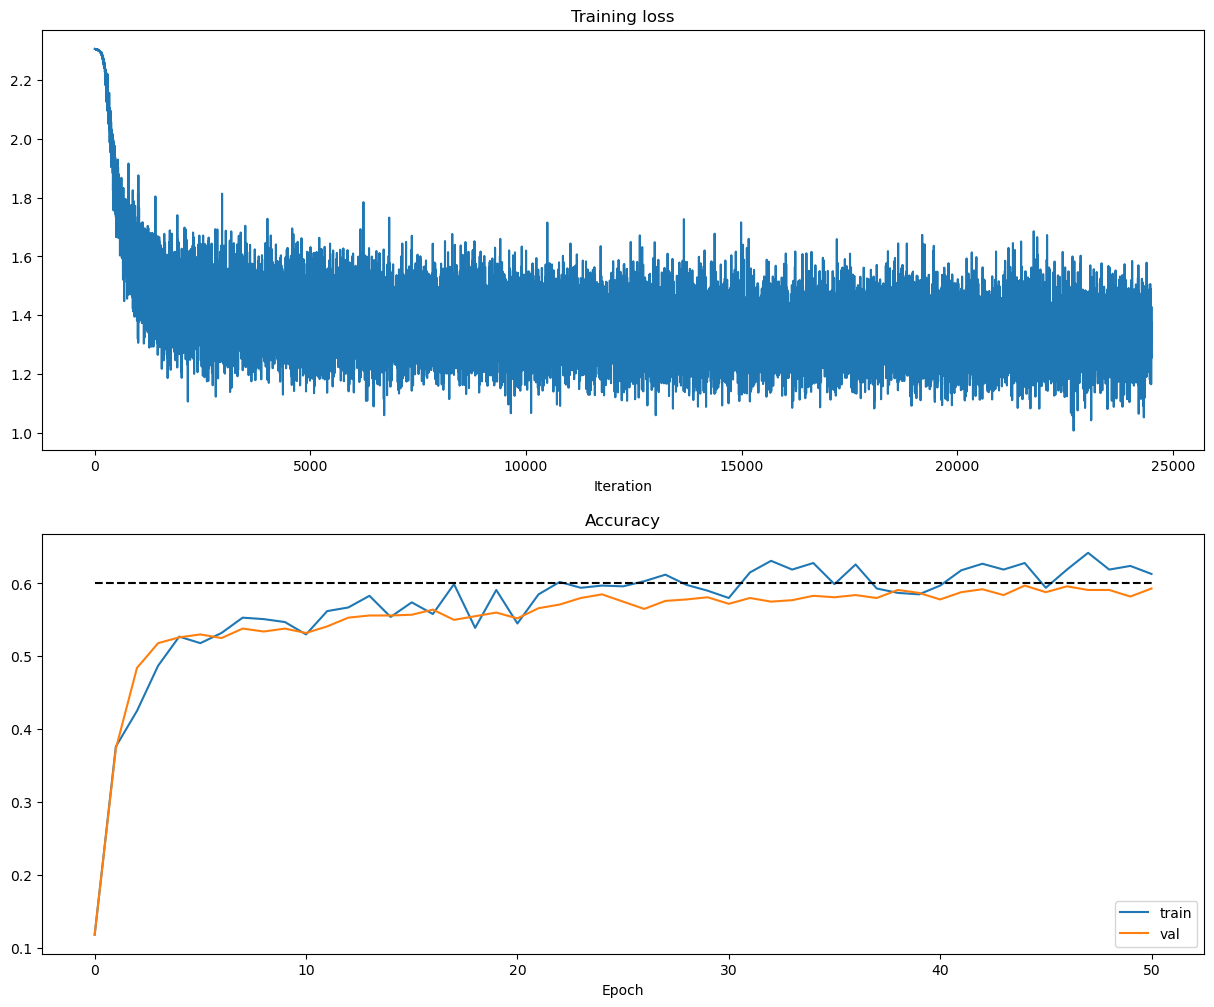

best_val_acc: 0.597
Training exp 7: lr = 0.002913218578384094, hidden_dim = 983, reg = 0.009042063554624006


100%|██████████| 24500/24500 [12:01<00:00, 33.97it/s]


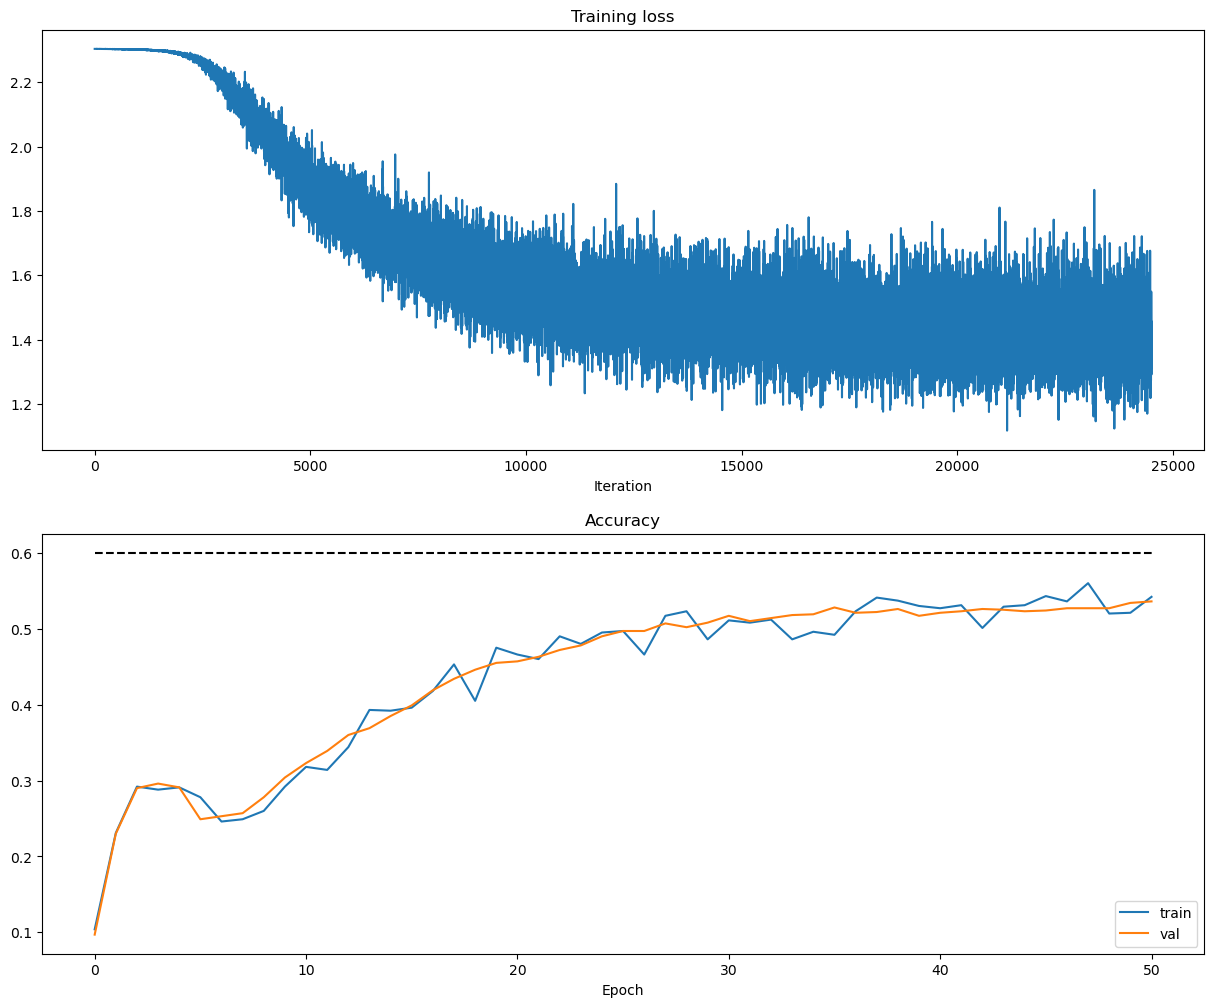

best_val_acc: 0.536
Training exp 8: lr = 0.008820034450746453, hidden_dim = 4437, reg = 0.002097522278770623


100%|██████████| 24500/24500 [56:58<00:00,  7.17it/s] 


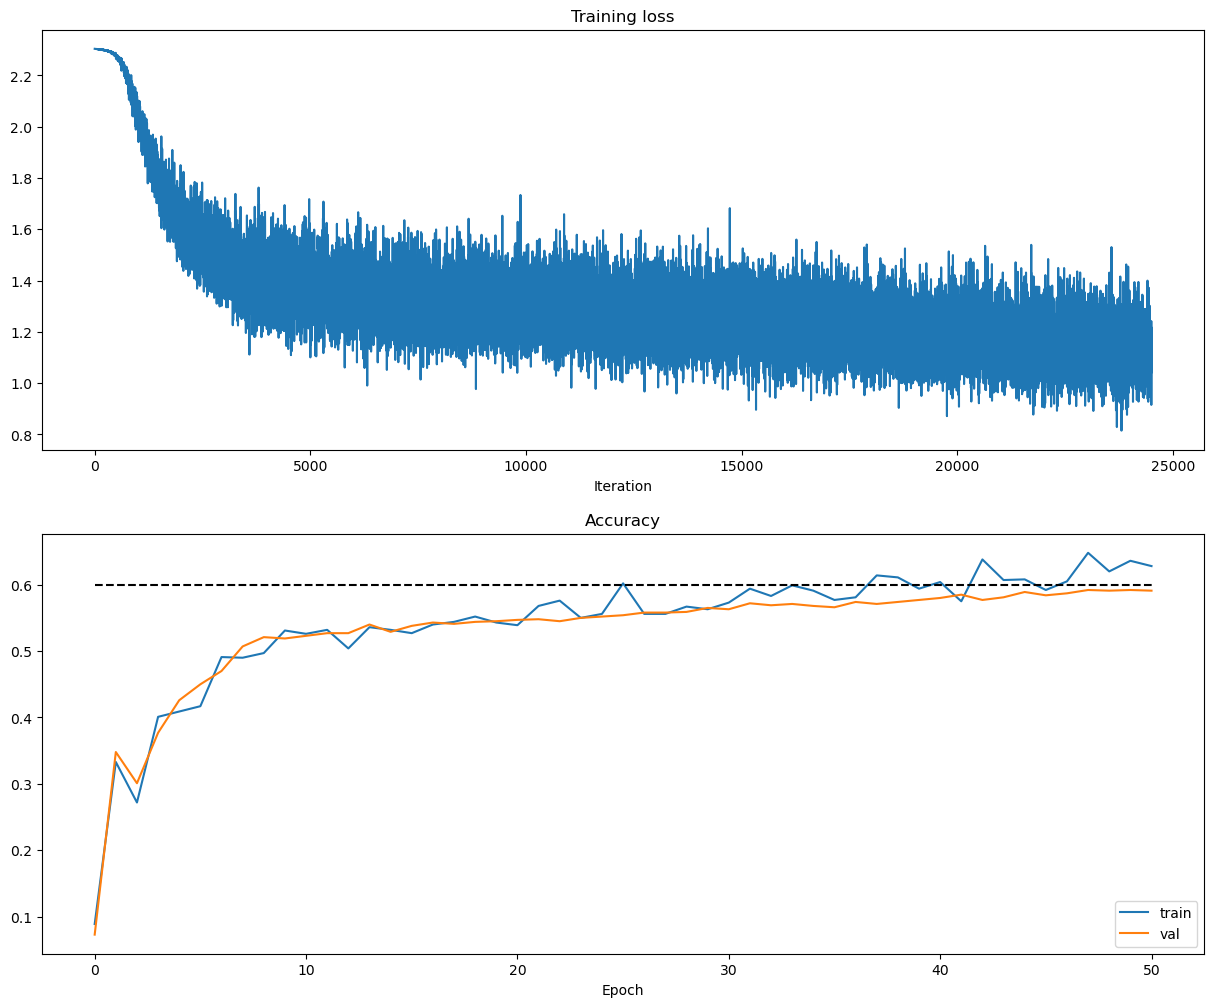

best_val_acc: 0.592
Training exp 9: lr = 0.08172567786707882, hidden_dim = 2072, reg = 0.0029226048421351234


100%|██████████| 24500/24500 [25:10<00:00, 16.22it/s]


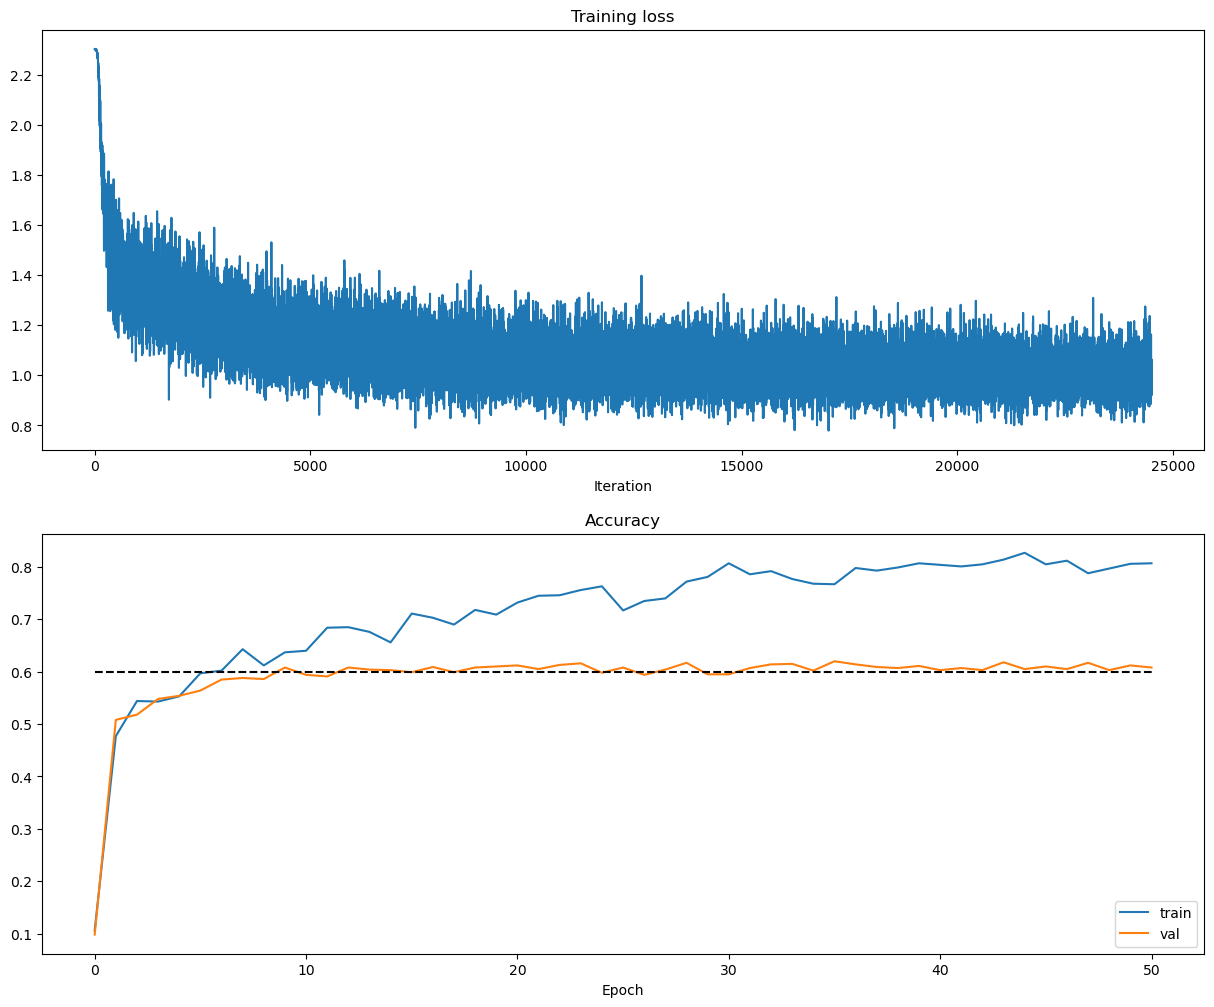

best_val_acc: 0.62


In [16]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val_acc = -1

for i in range(10):
    lr = 10 ** np.random.uniform(-3, -1)
    hidden_dim = np.random.randint(500, 5000)
    reg = 10 ** np.random.uniform(-5, 0)

    print(f'Training exp {i}: lr = {lr}, hidden_dim = {hidden_dim}, reg = {reg}')
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg)
    solver = Solver(net, data, optim_config={'learning_rate': lr}, num_epochs=50, verbose=False)
    solver.train()

    plt.subplot(2, 1, 1)
    plt.title('Training loss')
    plt.plot(solver.loss_history)
    plt.xlabel('Iteration')
    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(solver.train_acc_history, label='train')
    plt.plot(solver.val_acc_history, label='val')
    plt.plot([0.6] * len(solver.val_acc_history), 'k--')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()

    print(f'best_val_acc: {solver.best_val_acc}')

    if solver.best_val_acc > best_val_acc:
        best_val_acc = solver.best_val_acc
        best_net = solver.model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [17]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.607
